In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

#from torch.utils.tensorboard import SummaryWriter

import sklearn
import functools
import operator

import sys

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import dataset_class_gsimage
import vaenc_torch_net_class
#import aenc_utils
import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")
    
cpu_device = torch.device("cpu")

Utilizing CUDA


In [3]:
"""Download dataset provided by pytorch"""

from torchvision import datasets, transforms
# MNIST Dataset
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.])])

transform = torchvision.transforms.Compose([
                #dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                #dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                #torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

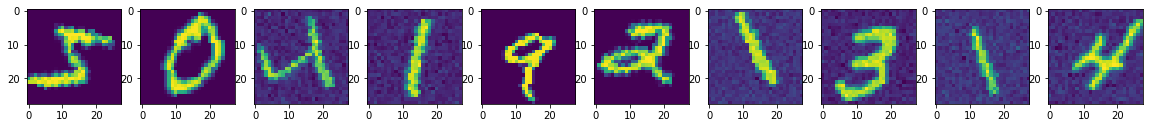

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(train_dataset[i][0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])

In [5]:
"""...But we will be using our custom dataset and functions!"""

#mnist_image_folder = "../data/mnist/"
#folder of the dataset
mnist_image_folder = "/media/data/sbulusu/datasets/mnist/mnist_images/"
mnist_image_names = os.listdir(mnist_image_folder)
#relative paths of all images to mnist_image_folder
mnist_image_paths = glob.glob("mnist/*")
image_size = [1,28,28]
#label_path_csv = "../data/mnist_labels.csv"
label_path_csv = "/media/data/sbulusu/datasets/mnist/mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform="default", device=device)
#dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform=None, device=device)
#name of the attribute in the csv file
target_attributes = ["number"]
dataset.set_label_names(target_attributes)

['number']

In [6]:

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])


/home/sbulusu/qcd_ml/neural_networks/libs/dataset_class_gsimage.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor.clone(), dtype=self.typ)


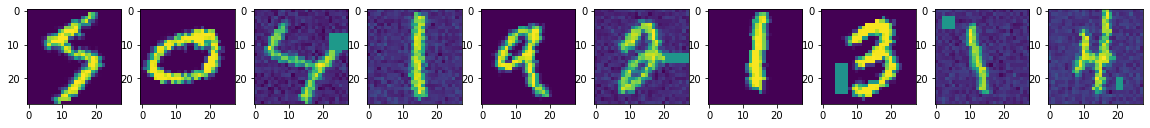

In [7]:

plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(dataset.get_image(i)[0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])


In [8]:

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.], std=[1.0]),
                #torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])


In [9]:


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

input_size = dataset.get_input_size()
output_size = input_size

latent_size = 20

fc_input_size = np.product(input_size)
print(fc_input_size)

784


In [10]:

act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid
encoder_struct = []

"""
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
encoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": 800}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 800, "out_features": 400}, "bias": True} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 400, "out_features": latent_size}, "bias": True} )
"""

encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
#encoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//2}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//2, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": latent_size}, "bias": True, "act_func": act_func} )


"""
act_func = torch.relu
#act_func = torch.sigmoid

encoder_struct = []
kernel_pars = [ [[1,2],[3,3],1,0], [[2,2],[2,2],2,0], [[2,4],[2,2],1,0], [[4,4],[2,2],2,0], [[4,4],[4,4],2,0]]
act_func = torch.relu

for i, kernel_par in enumerate(kernel_pars):
    if i%2 == 0:
        layer_type = nn.Conv2d
        encoder_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    else:
        layer_type = nn.MaxPool2d
        encoder_struct.append( {"type": layer_type, "layer_pars": {"kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3]}} )
        
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
"""

encoder_sizes = utils.calc_layer_sizes(input_size, encoder_struct)
print(encoder_sizes)

latent_size = encoder_sizes[-1]
input_size = encoder_sizes[0]

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
[[1, 28, 28], 784, 392, 196, 98, 20]


In [11]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid
decoder_struct = []

"""
decoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size//2, "out_features": 400}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 400, "out_features": 800}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 800, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )
"""

#decoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size//2, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )


"""
decoder_struct = []

decoder_input_shape = encoder_sizes[-2]
#input channel size for deconvolution
decoder_input_shape[0] = decoder_input_shape[0]//2

dc = decoder_input_shape[0]
#reverse above kernel_pars = [ [[dc,dc],[2,2],2,1], [[dc,dc],[2,2],2,1], [[dc,dc],[3,3],2,2], [[dc,dc],[3,3],2,2], [[dc,1],[4,4],2,2]]
kernel_pars = kernel_pars[::-1]
for kernel_par in kernel_pars:
    kernel_par[0][0] = dc
    kernel_par[0][1] = dc
act_func = torch.relu

decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": decoder_input_shape}} )

for i, kernel_par in enumerate(kernel_pars):
    #if i%2 == 0:
    layer_type = nn.ConvTranspose2d
    decoder_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    
        
#output channel size      
decoder_struct[-1]["layer_pars"]["out_channels"] = 1
"""

decoder_sizes = utils.calc_layer_sizes(latent_size//2, decoder_struct)

print(decoder_sizes)

0
<class 'torch.nn.modules.linear.Linear'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'utils.Reshape'>
[10, 49, 98, 196, 784, [1, 28, 28]]


In [12]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#val_epochs = [10,20,30,40,50,60,70]
#val_epochs = list(range(0,50))
val_epochs = list(range(0,100))
#val_epochs = [10,15,20,25,30,35,40,45]
#val_epochs = [0,1,2,3,4,5,6,7,8,9,10,15,20]
#val_epochs = [0,1]

#save states of the network for particular epochs, sate can be reloaded afterwards!
save_state_epochs = [10000]


"""create list of parameters manually"""

hyper_parameters = {}
loss_func_kwargs = {"reduction": "sum"}
#hyper_parameters["loss_func"] = nn.CrossEntropyLoss
#hyper_parameters["loss_func"] = nn.BCELoss
hyper_parameters["loss_func"] = nn.MSELoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 10
hyper_parameters["lr"] = 0.00001

hyper_parameters["gamma"] = 0.001

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

In [13]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
gamma = hyper_parameters["gamma"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"](**loss_func_kwargs)
#loss_func = hyper_parameters["loss_func"]()
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [14]:
"""Generate network class instance"""
net = vaenc_torch_net_class.AutoEncoder(encoder_struct=encoder_struct, decoder_struct=decoder_struct, input_size=input_size, latent_size=latent_size, device=device)
net.set_batch_size(batch_size)
net.to(device)
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
Initializing Encoder:

Adding {'type': <class 'torch.nn.modules.flatten.Flatten'>, 'layer_pars': {'start_dim': 1}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 784, 'out_features': 392}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fb6bed7cbe0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 392, 'out_features': 196}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fb6bed7cbe0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 196, 'out_features': 98}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fb6bed7cbe0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars':

In [15]:
"""Load and split data"""

split_indices = utils.load_split_indices(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, shuffle=True, random_seed=random_seed, log_file=log_file)

train_indices = split_indices[0][0]
val_indices = split_indices[0][1]
test_indices = split_indices[0][2]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


size of val set :1112

size of train set :8888




mean epoch 0 train loss: 1169.416607405123



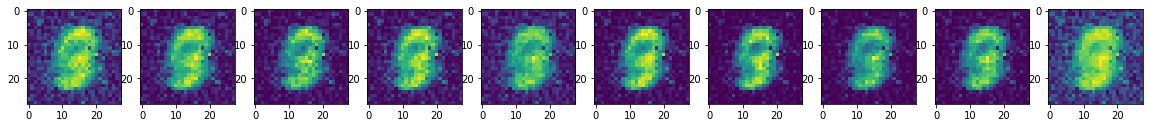


mean epoch 0 val loss: 584.9452241488865

Saving validation results for epoch 0
validation prediction: val/val_epoch_0_pred
validation label: val/val_epoch_0_labels



mean epoch 1 train loss: 565.8014793782186



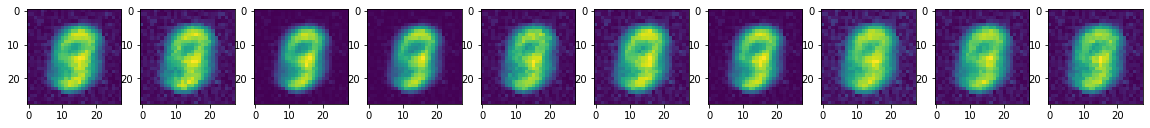


mean epoch 1 val loss: 546.582432951246

Saving validation results for epoch 1
validation prediction: val/val_epoch_1_pred
validation label: val/val_epoch_1_labels



mean epoch 2 train loss: 542.9873152948471



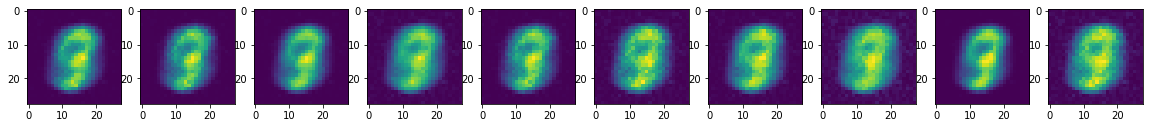


mean epoch 2 val loss: 530.9946896008083

Saving validation results for epoch 2
validation prediction: val/val_epoch_2_pred
validation label: val/val_epoch_2_labels



mean epoch 3 train loss: 530.1545693705401



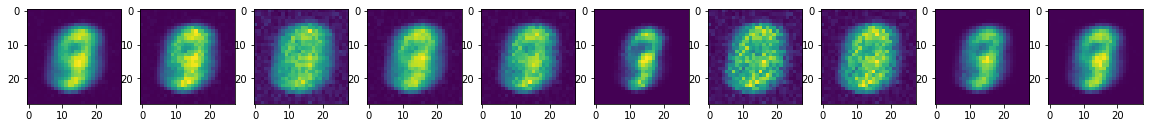


mean epoch 3 val loss: 519.4014915738787

Saving validation results for epoch 3
validation prediction: val/val_epoch_3_pred
validation label: val/val_epoch_3_labels



mean epoch 4 train loss: 517.3746993211847



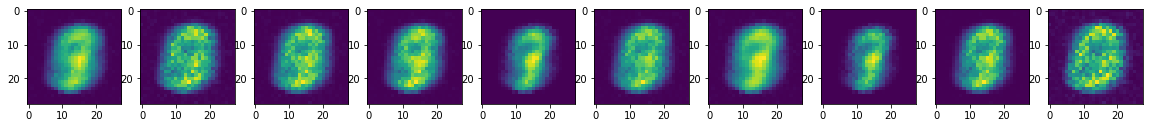


mean epoch 4 val loss: 505.3509366171701

Saving validation results for epoch 4
validation prediction: val/val_epoch_4_pred
validation label: val/val_epoch_4_labels



mean epoch 5 train loss: 502.61635817022506



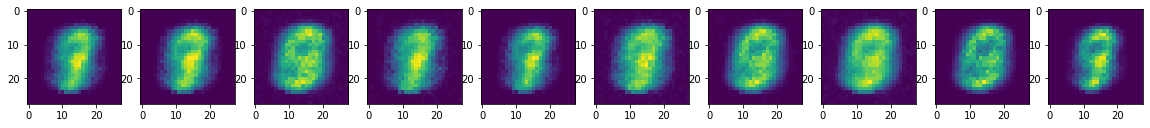


mean epoch 5 val loss: 490.6952875682286

Saving validation results for epoch 5
validation prediction: val/val_epoch_5_pred
validation label: val/val_epoch_5_labels



mean epoch 6 train loss: 488.588937628524



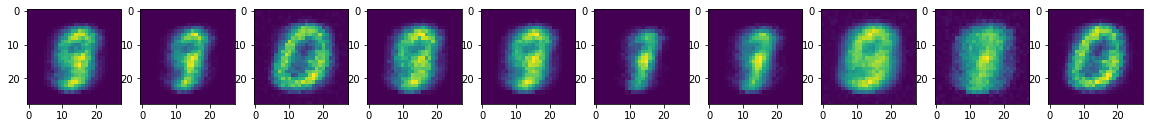


mean epoch 6 val loss: 478.4334047862462

Saving validation results for epoch 6
validation prediction: val/val_epoch_6_pred
validation label: val/val_epoch_6_labels



mean epoch 7 train loss: 477.5056213447562



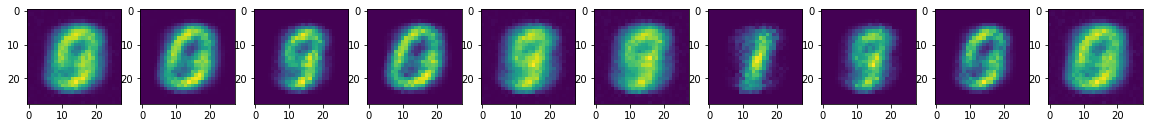


mean epoch 7 val loss: 469.02312660217285

Saving validation results for epoch 7
validation prediction: val/val_epoch_7_pred
validation label: val/val_epoch_7_labels



mean epoch 8 train loss: 468.3577484371155



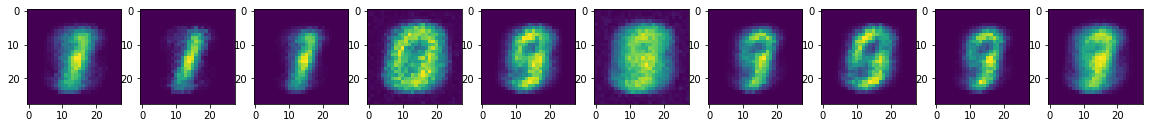


mean epoch 8 val loss: 460.8212048666818

Saving validation results for epoch 8
validation prediction: val/val_epoch_8_pred
validation label: val/val_epoch_8_labels



mean epoch 9 train loss: 460.010374843739



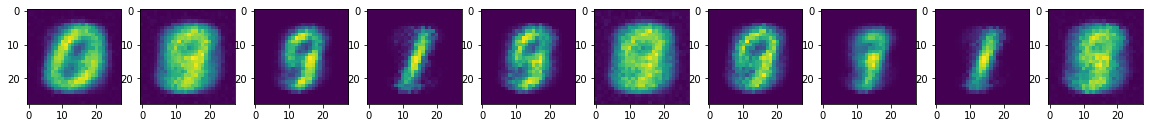


mean epoch 9 val loss: 452.87242405755177

Saving validation results for epoch 9
validation prediction: val/val_epoch_9_pred
validation label: val/val_epoch_9_labels



mean epoch 10 train loss: 450.524561398209



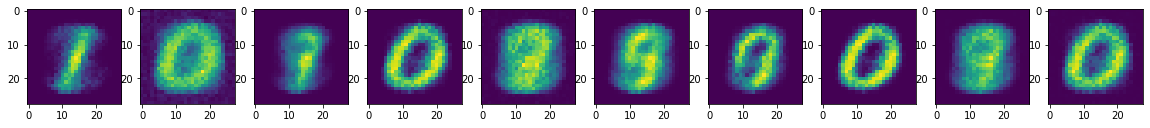


mean epoch 10 val loss: 442.9494011742728

Saving validation results for epoch 10
validation prediction: val/val_epoch_10_pred
validation label: val/val_epoch_10_labels



mean epoch 11 train loss: 439.20658639365024



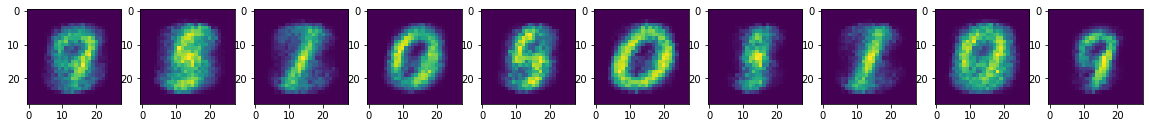


mean epoch 11 val loss: 430.7271021434239

Saving validation results for epoch 11
validation prediction: val/val_epoch_11_pred
validation label: val/val_epoch_11_labels



mean epoch 12 train loss: 427.2425611257821



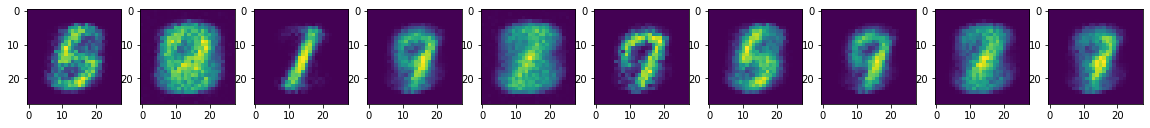


mean epoch 12 val loss: 418.0522008623396

Saving validation results for epoch 12
validation prediction: val/val_epoch_12_pred
validation label: val/val_epoch_12_labels



mean epoch 13 train loss: 415.6775322861559



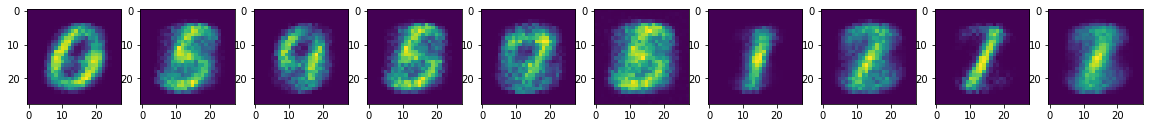


mean epoch 13 val loss: 406.03838334764754

Saving validation results for epoch 13
validation prediction: val/val_epoch_13_pred
validation label: val/val_epoch_13_labels



mean epoch 14 train loss: 405.29793786305277



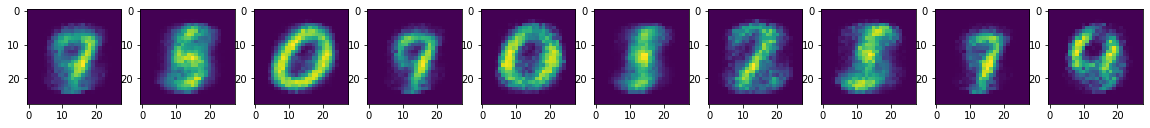


mean epoch 14 val loss: 396.2906009469713

Saving validation results for epoch 14
validation prediction: val/val_epoch_14_pred
validation label: val/val_epoch_14_labels



mean epoch 15 train loss: 396.2905047559363



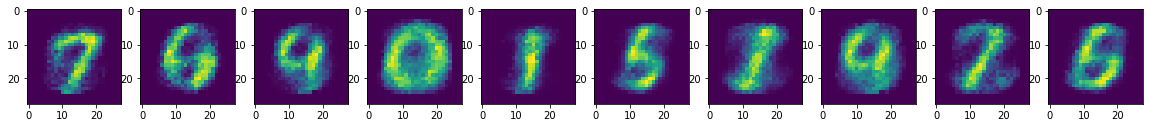


mean epoch 15 val loss: 387.0895624841963

Saving validation results for epoch 15
validation prediction: val/val_epoch_15_pred
validation label: val/val_epoch_15_labels



mean epoch 16 train loss: 388.3109390378937



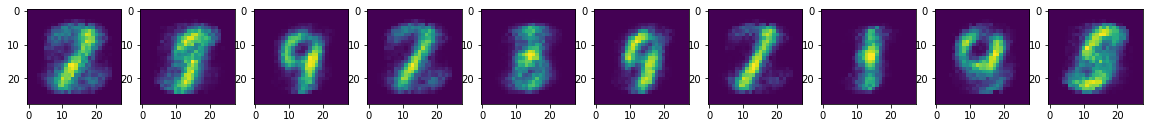


mean epoch 16 val loss: 378.7737945829119

Saving validation results for epoch 16
validation prediction: val/val_epoch_16_pred
validation label: val/val_epoch_16_labels



mean epoch 17 train loss: 380.48448637714534



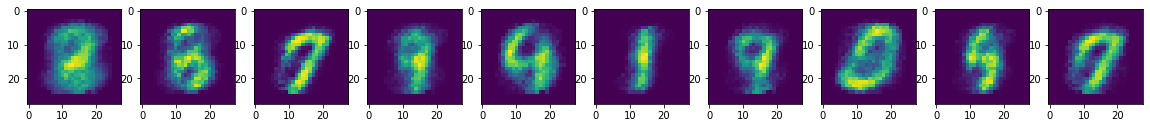


mean epoch 17 val loss: 370.67422076634

Saving validation results for epoch 17
validation prediction: val/val_epoch_17_pred
validation label: val/val_epoch_17_labels



mean epoch 18 train loss: 372.44773090650045



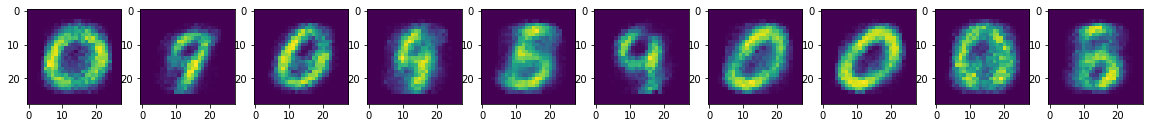


mean epoch 18 val loss: 362.4787063598633

Saving validation results for epoch 18
validation prediction: val/val_epoch_18_pred
validation label: val/val_epoch_18_labels



mean epoch 19 train loss: 363.9300403573516



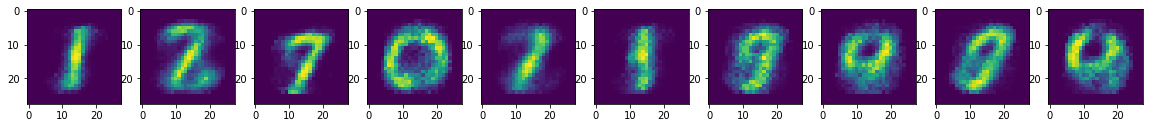


mean epoch 19 val loss: 353.32504783357894

Saving validation results for epoch 19
validation prediction: val/val_epoch_19_pred
validation label: val/val_epoch_19_labels



mean epoch 20 train loss: 355.1992917656228



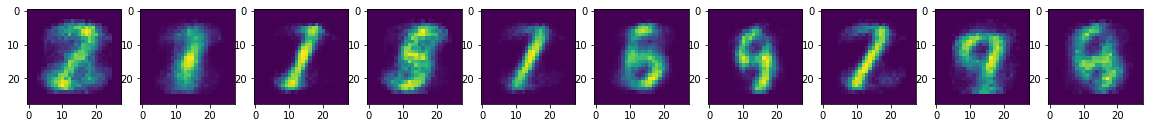


mean epoch 20 val loss: 345.5428432737078

Saving validation results for epoch 20
validation prediction: val/val_epoch_20_pred
validation label: val/val_epoch_20_labels



mean epoch 21 train loss: 346.7690607506459



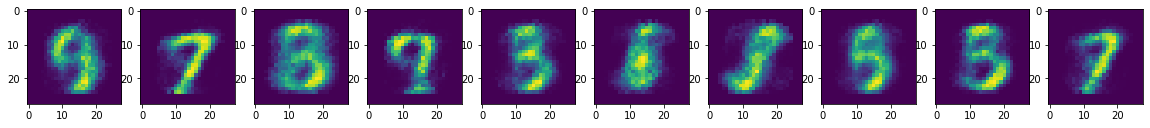


mean epoch 21 val loss: 337.6213369369507

Saving validation results for epoch 21
validation prediction: val/val_epoch_21_pred
validation label: val/val_epoch_21_labels



mean epoch 22 train loss: 339.72932670945124



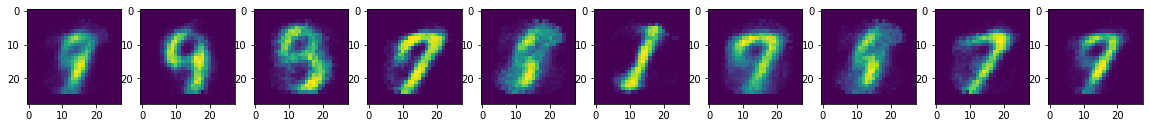


mean epoch 22 val loss: 331.46794056892395

Saving validation results for epoch 22
validation prediction: val/val_epoch_22_pred
validation label: val/val_epoch_22_labels



mean epoch 23 train loss: 333.87720433718977



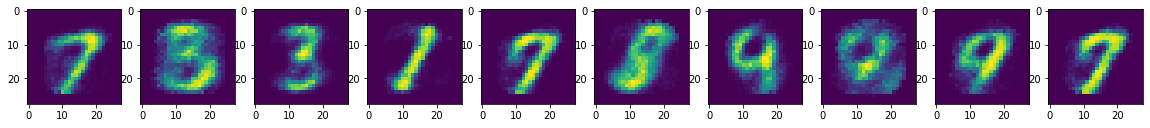


mean epoch 23 val loss: 326.25210063798085

Saving validation results for epoch 23
validation prediction: val/val_epoch_23_pred
validation label: val/val_epoch_23_labels



mean epoch 24 train loss: 329.19955293292804



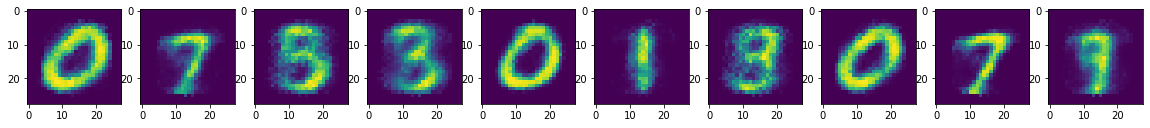


mean epoch 24 val loss: 322.0139211927141

Saving validation results for epoch 24
validation prediction: val/val_epoch_24_pred
validation label: val/val_epoch_24_labels



mean epoch 25 train loss: 325.0716361355862



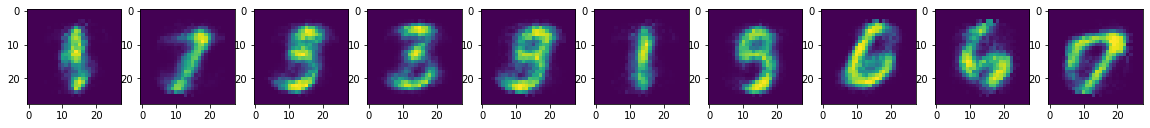


mean epoch 25 val loss: 317.8601499285017

Saving validation results for epoch 25
validation prediction: val/val_epoch_25_pred
validation label: val/val_epoch_25_labels



mean epoch 26 train loss: 321.7123436085687



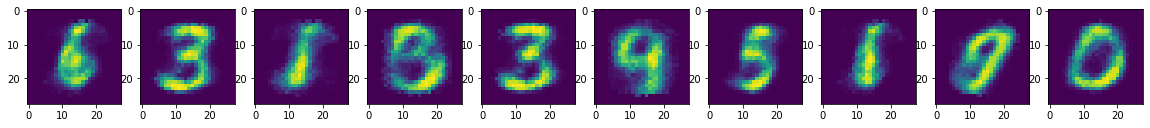


mean epoch 26 val loss: 315.1754900387355

Saving validation results for epoch 26
validation prediction: val/val_epoch_26_pred
validation label: val/val_epoch_26_labels



mean epoch 27 train loss: 318.7506013576306



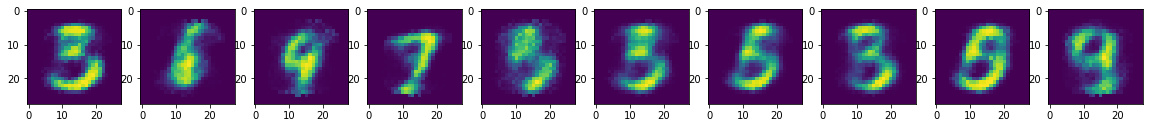


mean epoch 27 val loss: 312.2643500055586

Saving validation results for epoch 27
validation prediction: val/val_epoch_27_pred
validation label: val/val_epoch_27_labels



mean epoch 28 train loss: 316.0464390860902



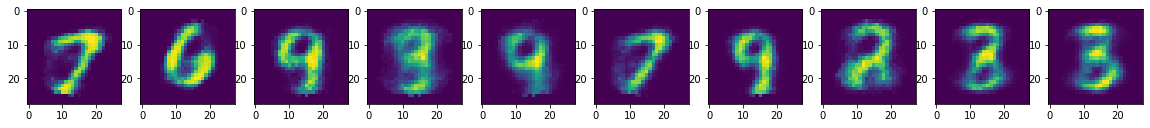


mean epoch 28 val loss: 309.5823667390006

Saving validation results for epoch 28
validation prediction: val/val_epoch_28_pred
validation label: val/val_epoch_28_labels



mean epoch 29 train loss: 313.6866689881538



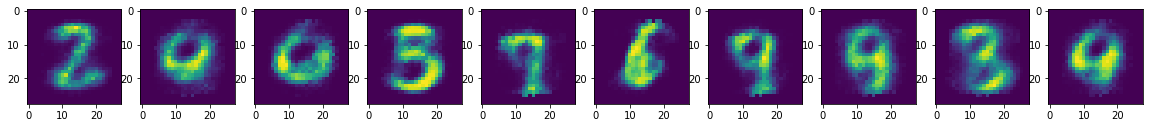


mean epoch 29 val loss: 307.7311863558633

Saving validation results for epoch 29
validation prediction: val/val_epoch_29_pred
validation label: val/val_epoch_29_labels



mean epoch 30 train loss: 311.4535963232257



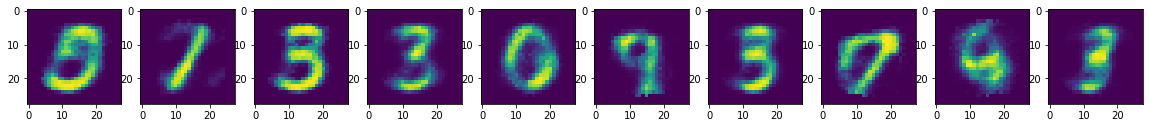


mean epoch 30 val loss: 305.482779775347

Saving validation results for epoch 30
validation prediction: val/val_epoch_30_pred
validation label: val/val_epoch_30_labels



mean epoch 31 train loss: 309.27989086927795



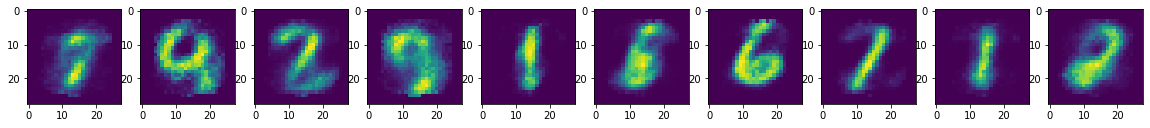


mean epoch 31 val loss: 303.8944001197815

Saving validation results for epoch 31
validation prediction: val/val_epoch_31_pred
validation label: val/val_epoch_31_labels



mean epoch 32 train loss: 307.05148543710783



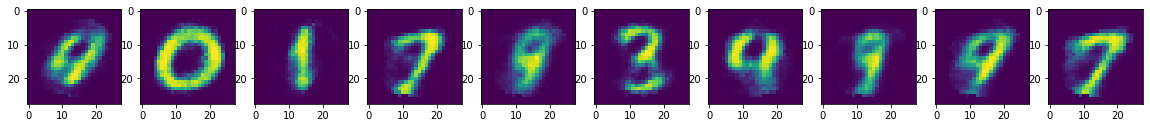


mean epoch 32 val loss: 301.33625313213895

Saving validation results for epoch 32
validation prediction: val/val_epoch_32_pred
validation label: val/val_epoch_32_labels



mean epoch 33 train loss: 305.07631886742917



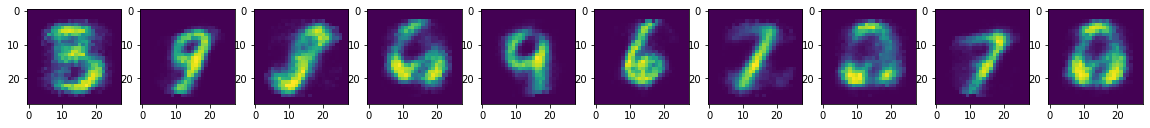


mean epoch 33 val loss: 299.2183481965746

Saving validation results for epoch 33
validation prediction: val/val_epoch_33_pred
validation label: val/val_epoch_33_labels



mean epoch 34 train loss: 302.7490978090782



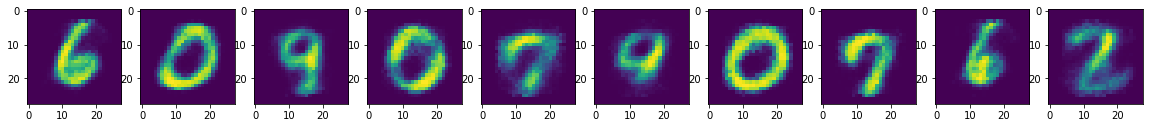


mean epoch 34 val loss: 297.3481299536569

Saving validation results for epoch 34
validation prediction: val/val_epoch_34_pred
validation label: val/val_epoch_34_labels



mean epoch 35 train loss: 300.54610289497504



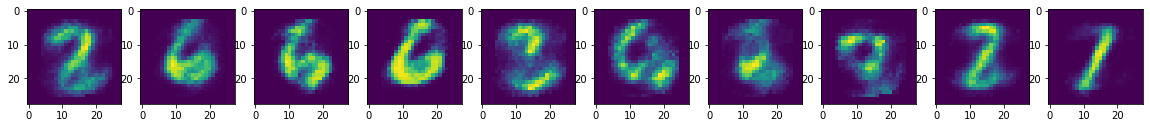


mean epoch 35 val loss: 294.8014464718955

Saving validation results for epoch 35
validation prediction: val/val_epoch_35_pred
validation label: val/val_epoch_35_labels



mean epoch 36 train loss: 298.8100734406033



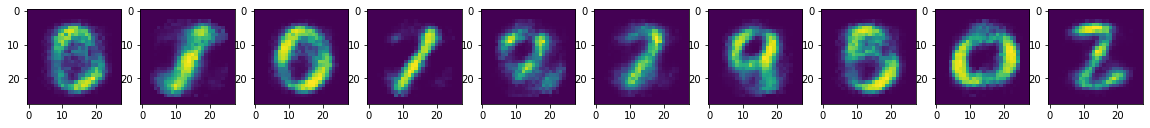


mean epoch 36 val loss: 293.71855085236683

Saving validation results for epoch 36
validation prediction: val/val_epoch_36_pred
validation label: val/val_epoch_36_labels



mean epoch 37 train loss: 296.55517018578854



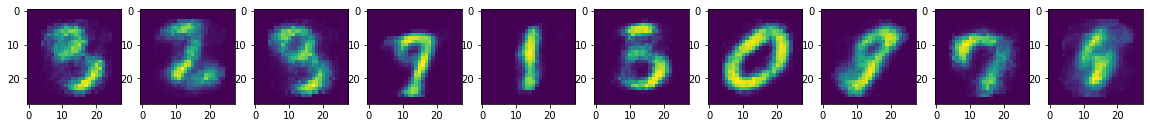


mean epoch 37 val loss: 291.43094635009766

Saving validation results for epoch 37
validation prediction: val/val_epoch_37_pred
validation label: val/val_epoch_37_labels



mean epoch 38 train loss: 294.7894282990017



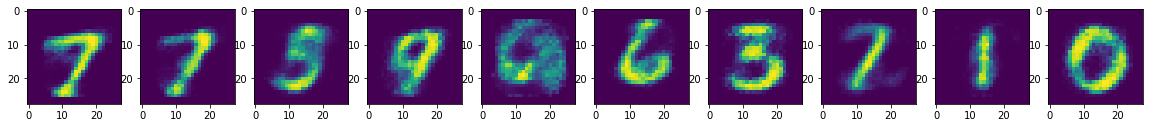


mean epoch 38 val loss: 290.4056382519858

Saving validation results for epoch 38
validation prediction: val/val_epoch_38_pred
validation label: val/val_epoch_38_labels



mean epoch 39 train loss: 293.1485080096799



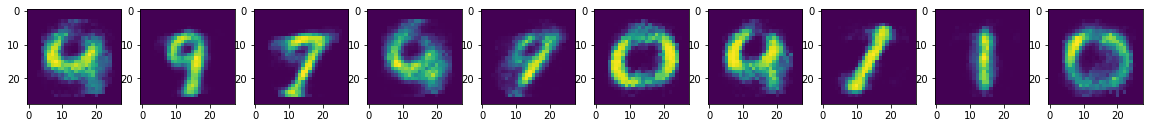


mean epoch 39 val loss: 288.1226801191057

Saving validation results for epoch 39
validation prediction: val/val_epoch_39_pred
validation label: val/val_epoch_39_labels



mean epoch 40 train loss: 291.52036730805986



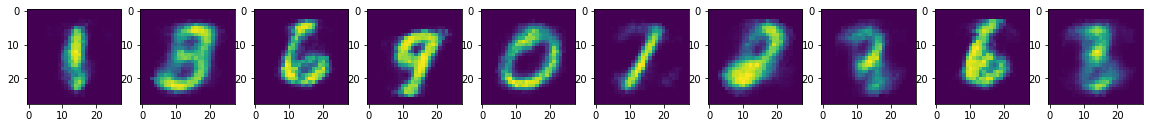


mean epoch 40 val loss: 286.836040360587

Saving validation results for epoch 40
validation prediction: val/val_epoch_40_pred
validation label: val/val_epoch_40_labels



mean epoch 41 train loss: 289.55518935796783



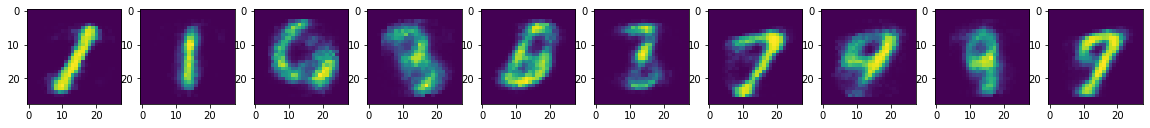


mean epoch 41 val loss: 285.3916314670018

Saving validation results for epoch 41
validation prediction: val/val_epoch_41_pred
validation label: val/val_epoch_41_labels



mean epoch 42 train loss: 288.1951976728922



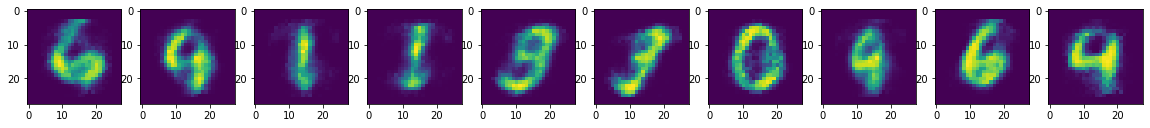


mean epoch 42 val loss: 283.5532080105373

Saving validation results for epoch 42
validation prediction: val/val_epoch_42_pred
validation label: val/val_epoch_42_labels



mean epoch 43 train loss: 286.6425173816316



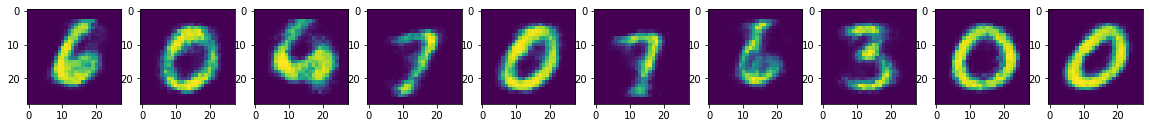


mean epoch 43 val loss: 282.2076553276607

Saving validation results for epoch 43
validation prediction: val/val_epoch_43_pred
validation label: val/val_epoch_43_labels



mean epoch 44 train loss: 285.06243302610244



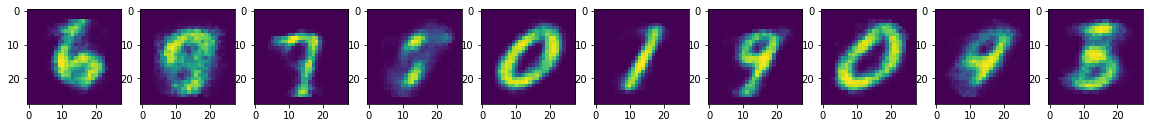


mean epoch 44 val loss: 280.55610425131664

Saving validation results for epoch 44
validation prediction: val/val_epoch_44_pred
validation label: val/val_epoch_44_labels



mean epoch 45 train loss: 283.7247956558073



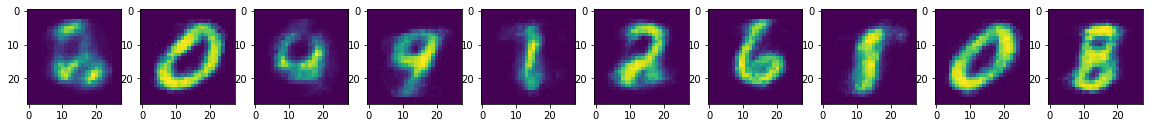


mean epoch 45 val loss: 279.30084930147444

Saving validation results for epoch 45
validation prediction: val/val_epoch_45_pred
validation label: val/val_epoch_45_labels



mean epoch 46 train loss: 282.29354334896675



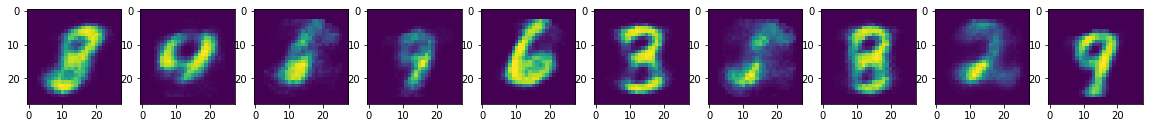


mean epoch 46 val loss: 277.9442864826747

Saving validation results for epoch 46
validation prediction: val/val_epoch_46_pred
validation label: val/val_epoch_46_labels



mean epoch 47 train loss: 280.7747206972206



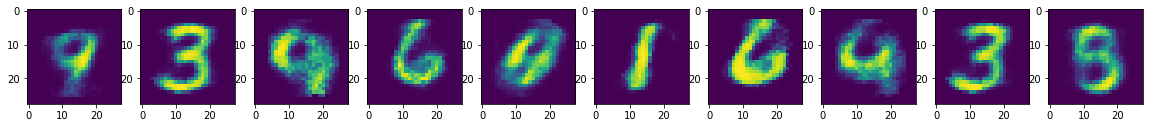


mean epoch 47 val loss: 276.72578838893344

Saving validation results for epoch 47
validation prediction: val/val_epoch_47_pred
validation label: val/val_epoch_47_labels



mean epoch 48 train loss: 279.3801897218445



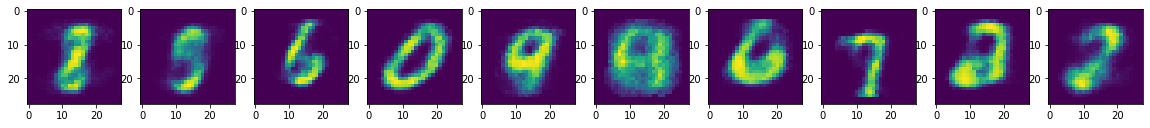


mean epoch 48 val loss: 275.3914886202131

Saving validation results for epoch 48
validation prediction: val/val_epoch_48_pred
validation label: val/val_epoch_48_labels



mean epoch 49 train loss: 278.02038833395034



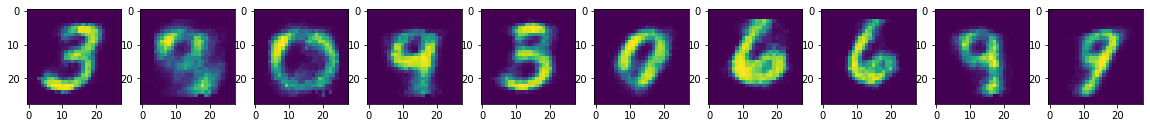


mean epoch 49 val loss: 274.1990839413234

Saving validation results for epoch 49
validation prediction: val/val_epoch_49_pred
validation label: val/val_epoch_49_labels



mean epoch 50 train loss: 276.5142006804356



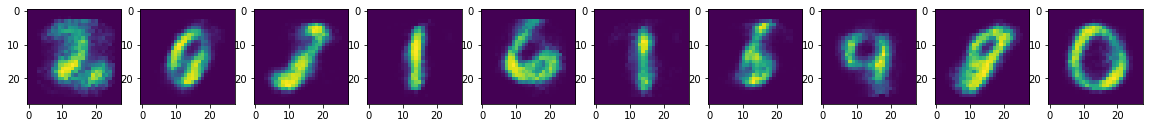


mean epoch 50 val loss: 272.4482412338257

Saving validation results for epoch 50
validation prediction: val/val_epoch_50_pred
validation label: val/val_epoch_50_labels



mean epoch 51 train loss: 275.24165100509595



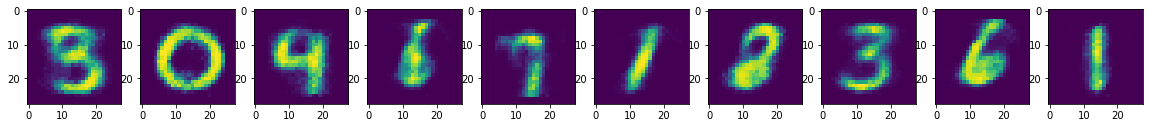


mean epoch 51 val loss: 270.74645570346286

Saving validation results for epoch 51
validation prediction: val/val_epoch_51_pred
validation label: val/val_epoch_51_labels



mean epoch 52 train loss: 273.842164201597



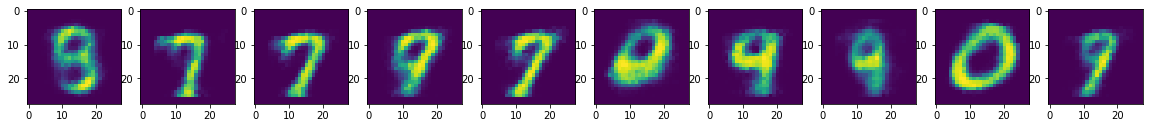


mean epoch 52 val loss: 270.10786523137773

Saving validation results for epoch 52
validation prediction: val/val_epoch_52_pred
validation label: val/val_epoch_52_labels



mean epoch 53 train loss: 272.522388368141



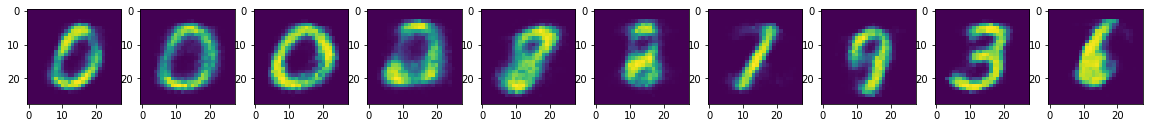


mean epoch 53 val loss: 269.2717751434871

Saving validation results for epoch 53
validation prediction: val/val_epoch_53_pred
validation label: val/val_epoch_53_labels



mean epoch 54 train loss: 271.3171686058774



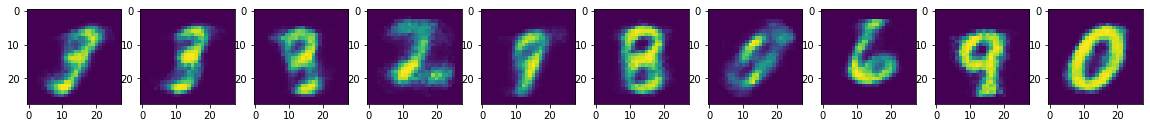


mean epoch 54 val loss: 267.25193125861034

Saving validation results for epoch 54
validation prediction: val/val_epoch_54_pred
validation label: val/val_epoch_54_labels



mean epoch 55 train loss: 270.0283705686692



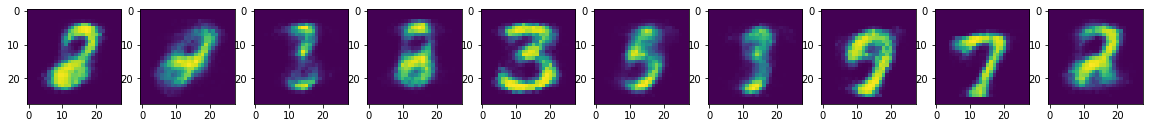


mean epoch 55 val loss: 266.0966144970485

Saving validation results for epoch 55
validation prediction: val/val_epoch_55_pred
validation label: val/val_epoch_55_labels



mean epoch 56 train loss: 268.6282314133188



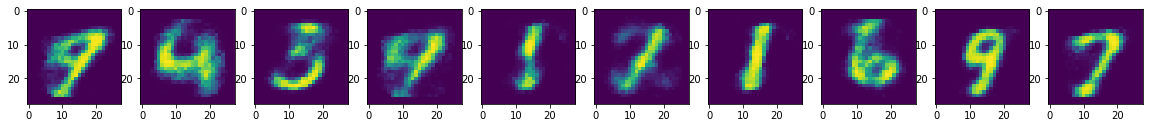


mean epoch 56 val loss: 264.703296491078

Saving validation results for epoch 56
validation prediction: val/val_epoch_56_pred
validation label: val/val_epoch_56_labels



mean epoch 57 train loss: 267.4869481227261



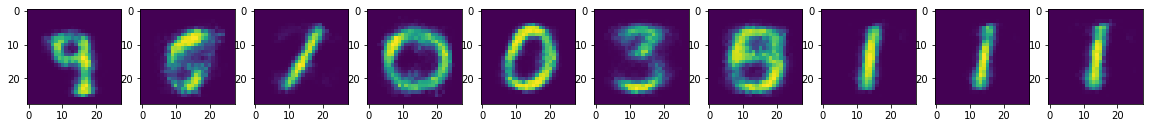


mean epoch 57 val loss: 264.0475767680577

Saving validation results for epoch 57
validation prediction: val/val_epoch_57_pred
validation label: val/val_epoch_57_labels



mean epoch 58 train loss: 266.38750872274085



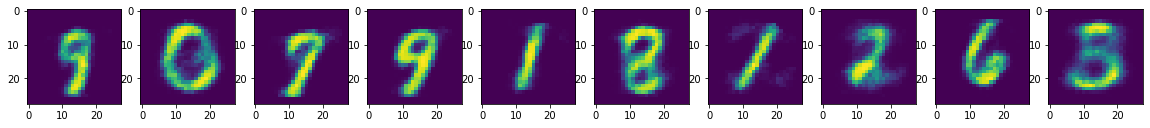


mean epoch 58 val loss: 262.8548571041652

Saving validation results for epoch 58
validation prediction: val/val_epoch_58_pred
validation label: val/val_epoch_58_labels



mean epoch 59 train loss: 265.29606329764505



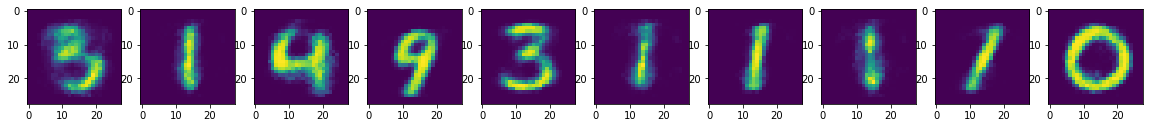


mean epoch 59 val loss: 261.39106042044506

Saving validation results for epoch 59
validation prediction: val/val_epoch_59_pred
validation label: val/val_epoch_59_labels



mean epoch 60 train loss: 263.76762263123175



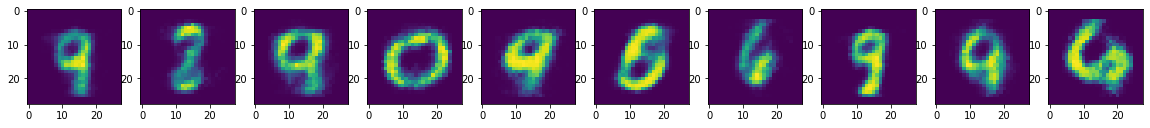


mean epoch 60 val loss: 259.9777716909136

Saving validation results for epoch 60
validation prediction: val/val_epoch_60_pred
validation label: val/val_epoch_60_labels



mean epoch 61 train loss: 262.9101823735961



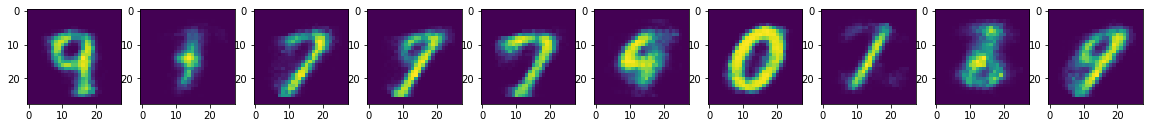


mean epoch 61 val loss: 259.46978664398193

Saving validation results for epoch 61
validation prediction: val/val_epoch_61_pred
validation label: val/val_epoch_61_labels



mean epoch 62 train loss: 261.8114532196079



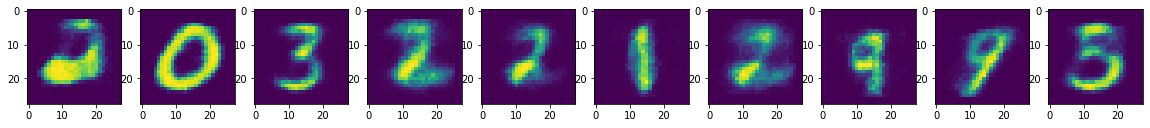


mean epoch 62 val loss: 258.5002384185791

Saving validation results for epoch 62
validation prediction: val/val_epoch_62_pred
validation label: val/val_epoch_62_labels



mean epoch 63 train loss: 260.4760438213198



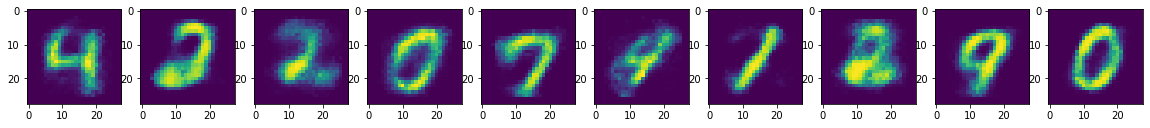


mean epoch 63 val loss: 256.65720060893466

Saving validation results for epoch 63
validation prediction: val/val_epoch_63_pred
validation label: val/val_epoch_63_labels



mean epoch 64 train loss: 259.56259182735823



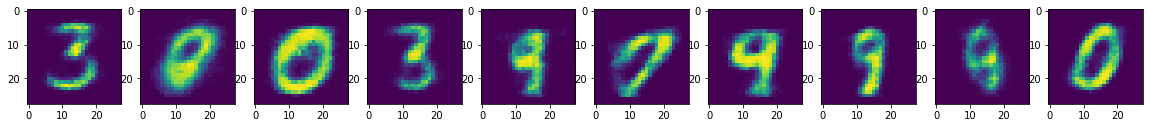


mean epoch 64 val loss: 256.7824561255319

Saving validation results for epoch 64
validation prediction: val/val_epoch_64_pred
validation label: val/val_epoch_64_labels



mean epoch 65 train loss: 258.648206506993



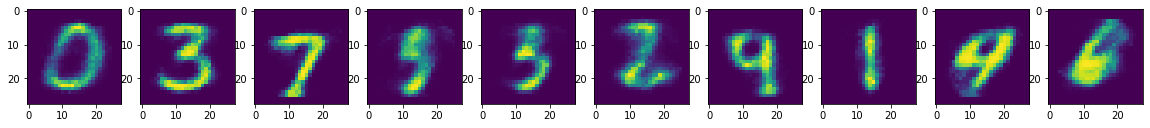


mean epoch 65 val loss: 255.66950266701835

Saving validation results for epoch 65
validation prediction: val/val_epoch_65_pred
validation label: val/val_epoch_65_labels



mean epoch 66 train loss: 257.5503772267877



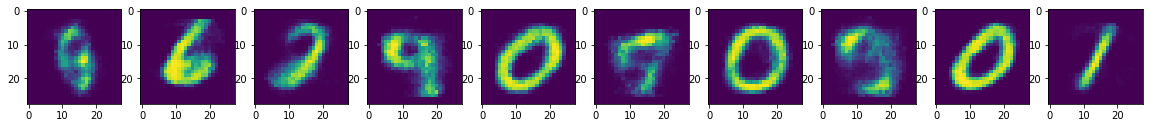


mean epoch 66 val loss: 254.6473364830017

Saving validation results for epoch 66
validation prediction: val/val_epoch_66_pred
validation label: val/val_epoch_66_labels



mean epoch 67 train loss: 256.64393732437804



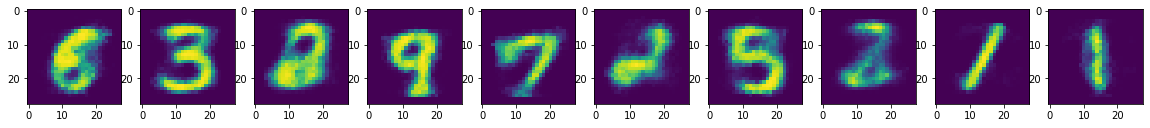


mean epoch 67 val loss: 254.4905277320317

Saving validation results for epoch 67
validation prediction: val/val_epoch_67_pred
validation label: val/val_epoch_67_labels



mean epoch 68 train loss: 255.56176105580798



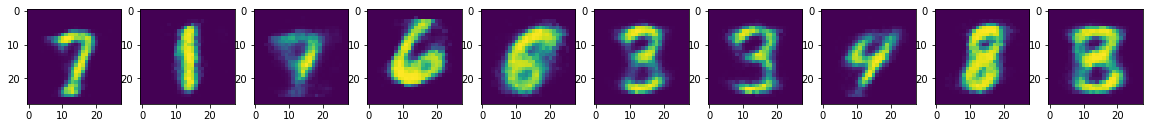


mean epoch 68 val loss: 252.4652098587581

Saving validation results for epoch 68
validation prediction: val/val_epoch_68_pred
validation label: val/val_epoch_68_labels



mean epoch 69 train loss: 254.7454110522104



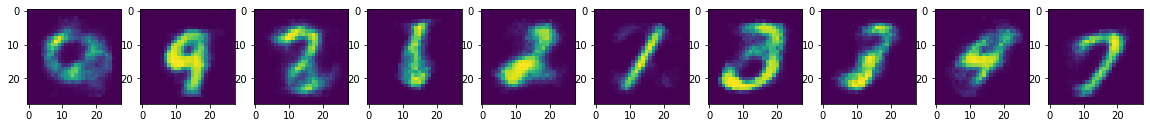


mean epoch 69 val loss: 252.03272765023368

Saving validation results for epoch 69
validation prediction: val/val_epoch_69_pred
validation label: val/val_epoch_69_labels



mean epoch 70 train loss: 253.76970378244957



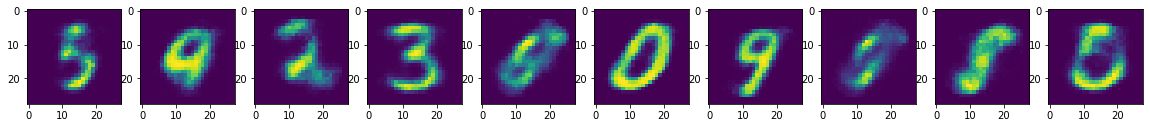


mean epoch 70 val loss: 251.9272016797747

Saving validation results for epoch 70
validation prediction: val/val_epoch_70_pred
validation label: val/val_epoch_70_labels



mean epoch 71 train loss: 252.84816535117253



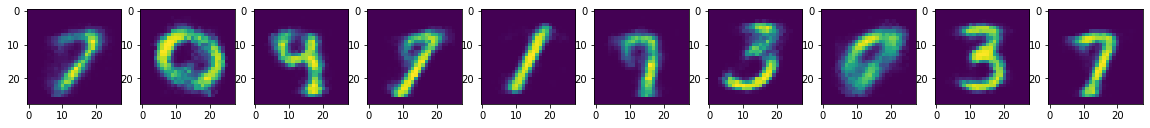


mean epoch 71 val loss: 250.50446328095026

Saving validation results for epoch 71
validation prediction: val/val_epoch_71_pred
validation label: val/val_epoch_71_labels



mean epoch 72 train loss: 251.9387598198632



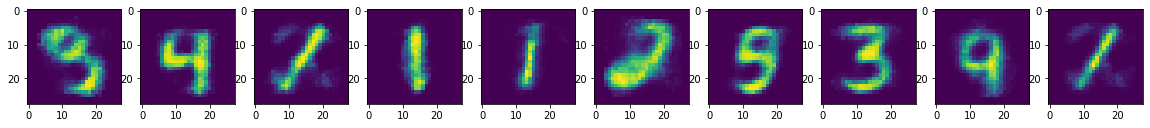


mean epoch 72 val loss: 249.0530421393258

Saving validation results for epoch 72
validation prediction: val/val_epoch_72_pred
validation label: val/val_epoch_72_labels



mean epoch 73 train loss: 250.97856696250065



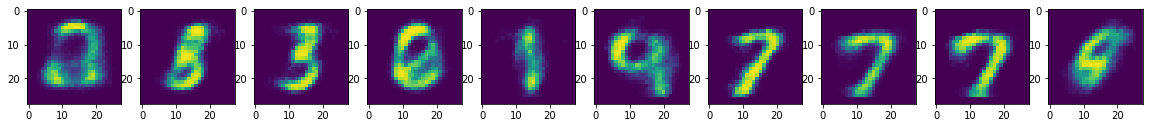


mean epoch 73 val loss: 249.41127756663732

Saving validation results for epoch 73
validation prediction: val/val_epoch_73_pred
validation label: val/val_epoch_73_labels



mean epoch 74 train loss: 250.2773109324469



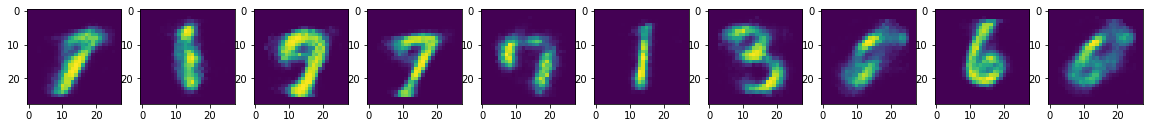


mean epoch 74 val loss: 247.4761871269771

Saving validation results for epoch 74
validation prediction: val/val_epoch_74_pred
validation label: val/val_epoch_74_labels



mean epoch 75 train loss: 249.376240450298



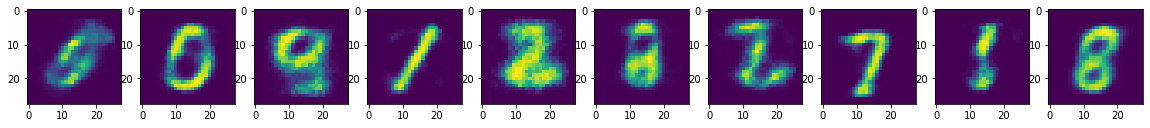


mean epoch 75 val loss: 247.07762272017342

Saving validation results for epoch 75
validation prediction: val/val_epoch_75_pred
validation label: val/val_epoch_75_labels



mean epoch 76 train loss: 248.4148138280124



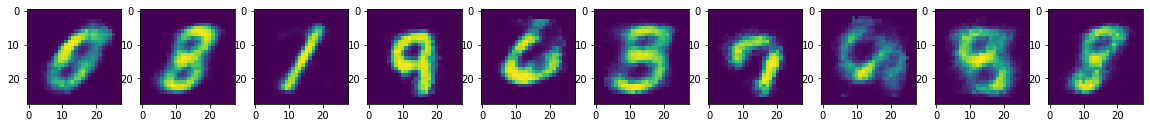


mean epoch 76 val loss: 246.6589674949646

Saving validation results for epoch 76
validation prediction: val/val_epoch_76_pred
validation label: val/val_epoch_76_labels



mean epoch 77 train loss: 247.58425328326575



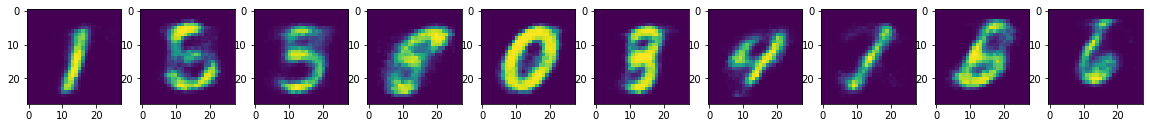


mean epoch 77 val loss: 245.82387266840254

Saving validation results for epoch 77
validation prediction: val/val_epoch_77_pred
validation label: val/val_epoch_77_labels



mean epoch 78 train loss: 246.80246814431703



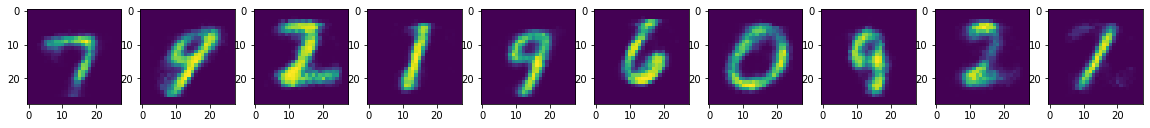


mean epoch 78 val loss: 244.89742612838745

Saving validation results for epoch 78
validation prediction: val/val_epoch_78_pred
validation label: val/val_epoch_78_labels



mean epoch 79 train loss: 245.87188523317215



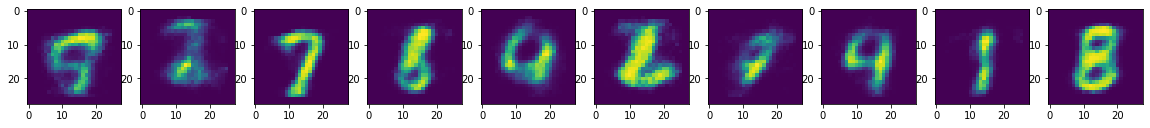


mean epoch 79 val loss: 243.50803565979004

Saving validation results for epoch 79
validation prediction: val/val_epoch_79_pred
validation label: val/val_epoch_79_labels



mean epoch 80 train loss: 245.22532142321626



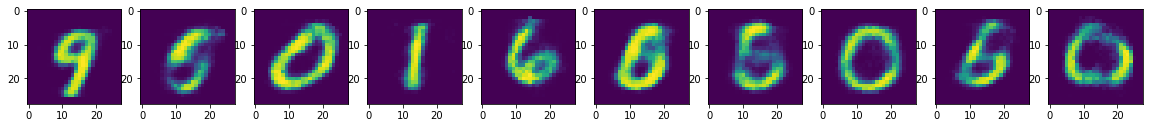


mean epoch 80 val loss: 243.26936095101493

Saving validation results for epoch 80
validation prediction: val/val_epoch_80_pred
validation label: val/val_epoch_80_labels



mean epoch 81 train loss: 244.54999356007013



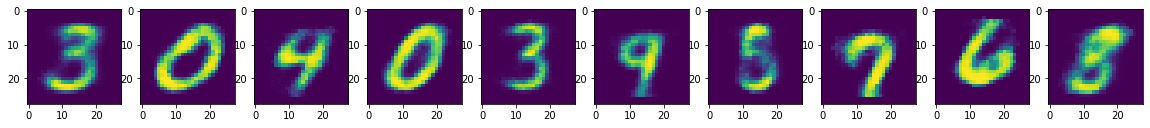


mean epoch 81 val loss: 242.7392646244594

Saving validation results for epoch 81
validation prediction: val/val_epoch_81_pred
validation label: val/val_epoch_81_labels



mean epoch 82 train loss: 243.9739618805584



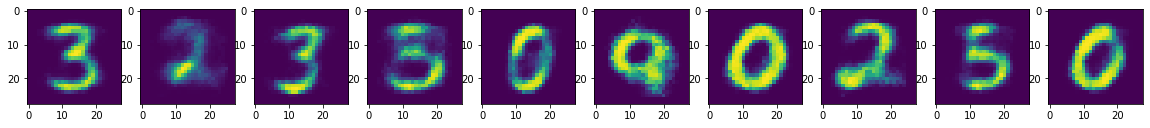


mean epoch 82 val loss: 242.17203388895308

Saving validation results for epoch 82
validation prediction: val/val_epoch_82_pred
validation label: val/val_epoch_82_labels



mean epoch 83 train loss: 242.92498228332727



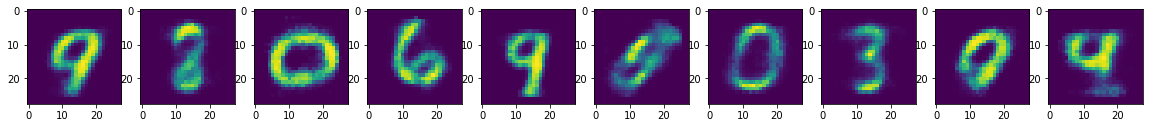


mean epoch 83 val loss: 241.6289886065892

Saving validation results for epoch 83
validation prediction: val/val_epoch_83_pred
validation label: val/val_epoch_83_labels



mean epoch 84 train loss: 242.21490279413317



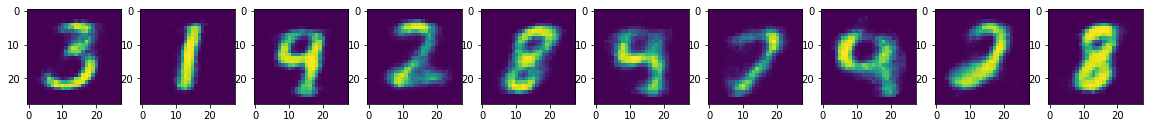


mean epoch 84 val loss: 240.54020742007665

Saving validation results for epoch 84
validation prediction: val/val_epoch_84_pred
validation label: val/val_epoch_84_labels



mean epoch 85 train loss: 241.57479866980432



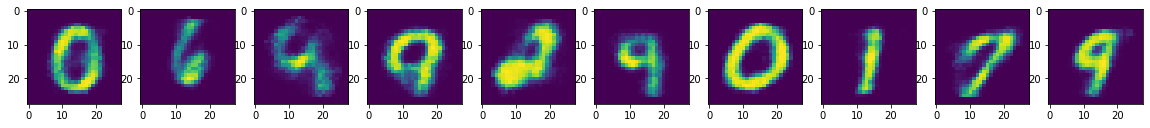


mean epoch 85 val loss: 239.88814546380723

Saving validation results for epoch 85
validation prediction: val/val_epoch_85_pred
validation label: val/val_epoch_85_labels



mean epoch 86 train loss: 240.78672339114348



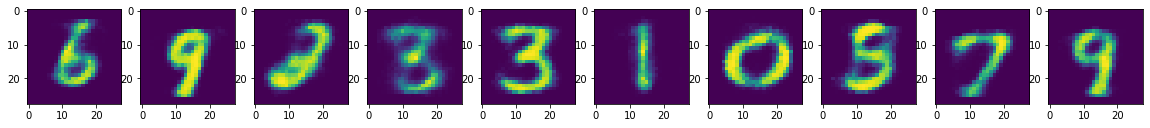


mean epoch 86 val loss: 239.40098718234472

Saving validation results for epoch 86
validation prediction: val/val_epoch_86_pred
validation label: val/val_epoch_86_labels



mean epoch 87 train loss: 240.31797560529847



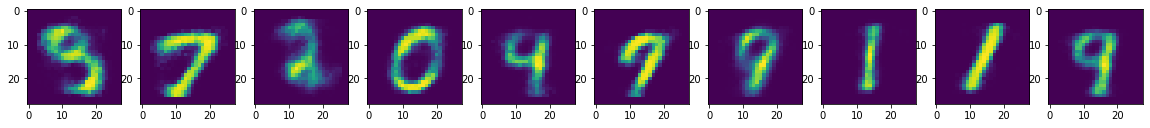


mean epoch 87 val loss: 238.69954381670271

Saving validation results for epoch 87
validation prediction: val/val_epoch_87_pred
validation label: val/val_epoch_87_labels



mean epoch 88 train loss: 239.4815468890058



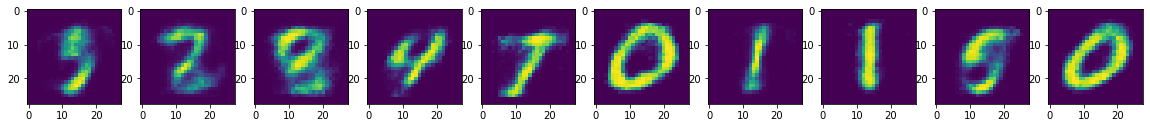


mean epoch 88 val loss: 238.41010587556022

Saving validation results for epoch 88
validation prediction: val/val_epoch_88_pred
validation label: val/val_epoch_88_labels



mean epoch 89 train loss: 239.03735914541443



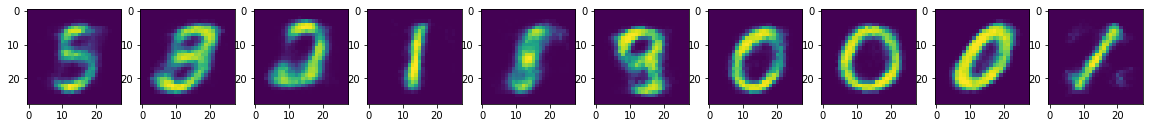


mean epoch 89 val loss: 238.130092893328

Saving validation results for epoch 89
validation prediction: val/val_epoch_89_pred
validation label: val/val_epoch_89_labels



mean epoch 90 train loss: 238.43969918799212



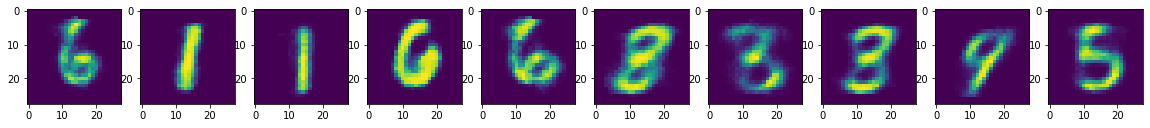


mean epoch 90 val loss: 236.96285203525

Saving validation results for epoch 90
validation prediction: val/val_epoch_90_pred
validation label: val/val_epoch_90_labels



mean epoch 91 train loss: 237.86725359853395



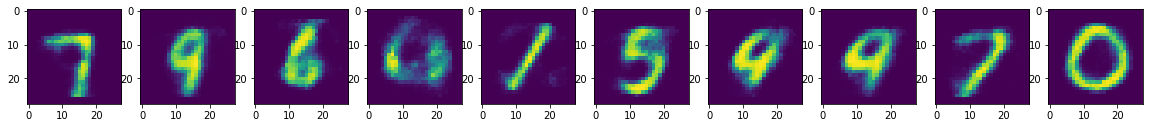


mean epoch 91 val loss: 236.93476331233978

Saving validation results for epoch 91
validation prediction: val/val_epoch_91_pred
validation label: val/val_epoch_91_labels



mean epoch 92 train loss: 237.14462707656844



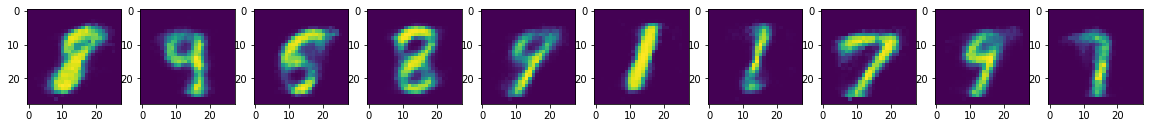


mean epoch 92 val loss: 236.04438761302404

Saving validation results for epoch 92
validation prediction: val/val_epoch_92_pred
validation label: val/val_epoch_92_labels



mean epoch 93 train loss: 236.4909735594879



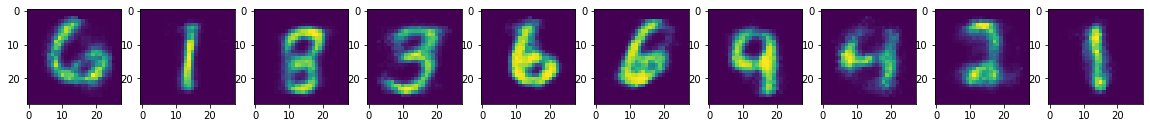


mean epoch 93 val loss: 235.47463280814034

Saving validation results for epoch 93
validation prediction: val/val_epoch_93_pred
validation label: val/val_epoch_93_labels



mean epoch 94 train loss: 236.1038021950137



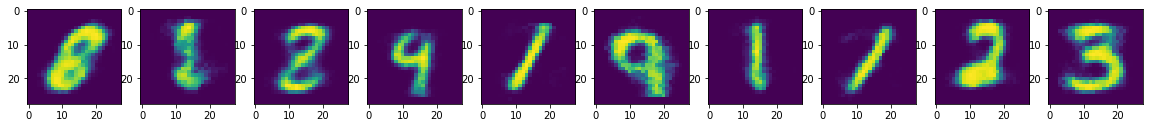


mean epoch 94 val loss: 234.90891405514307

Saving validation results for epoch 94
validation prediction: val/val_epoch_94_pred
validation label: val/val_epoch_94_labels



mean epoch 95 train loss: 235.33240293625101



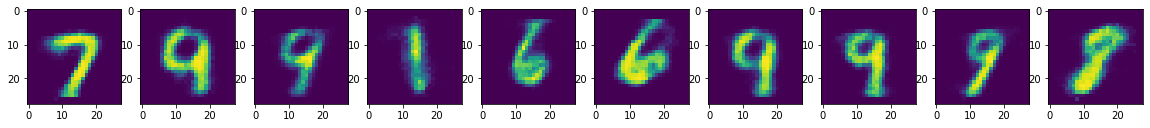


mean epoch 95 val loss: 234.6381619998387

Saving validation results for epoch 95
validation prediction: val/val_epoch_95_pred
validation label: val/val_epoch_95_labels



mean epoch 96 train loss: 234.98668789944043



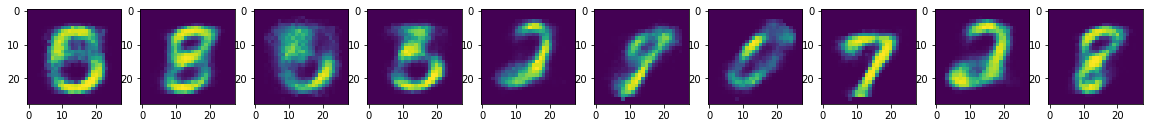


mean epoch 96 val loss: 234.18367058890206

Saving validation results for epoch 96
validation prediction: val/val_epoch_96_pred
validation label: val/val_epoch_96_labels



mean epoch 97 train loss: 234.33624416904857



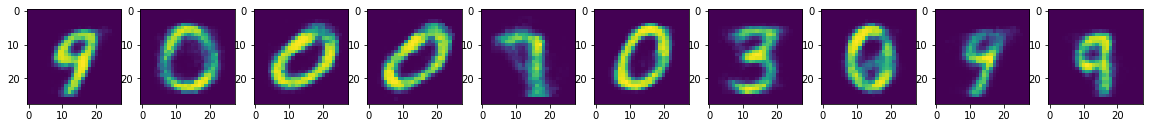


mean epoch 97 val loss: 232.9642264842987

Saving validation results for epoch 97
validation prediction: val/val_epoch_97_pred
validation label: val/val_epoch_97_labels



mean epoch 98 train loss: 233.83871549213697



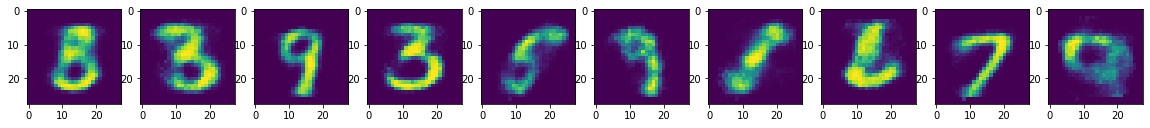


mean epoch 98 val loss: 233.35396463530404

Saving validation results for epoch 98
validation prediction: val/val_epoch_98_pred
validation label: val/val_epoch_98_labels



mean epoch 99 train loss: 233.2532257492014



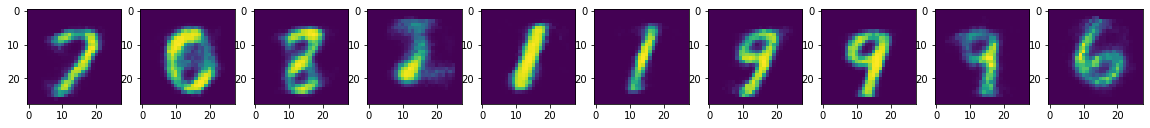


mean epoch 99 val loss: 232.35401395389013

Saving validation results for epoch 99
validation prediction: val/val_epoch_99_pred
validation label: val/val_epoch_99_labels



In [16]:
val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
train_start_time = time.time()
for epoch in tqdm(range(epochs)):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in tqdm(train_loader):
        
        batch_loss, train_output = utils.vstep(net, train_mini_batch[0], train_mini_batch[0], loss_func, gamma, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        #train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        #torch.save(train_state, train_state_epoch_file_path)
        torch.save(net.state_dict(), train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    #val_epochs = [100000]
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in tqdm(val_loader):
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.vstep(net, val_mini_batch[0], val_mini_batch[0], loss_func, gamma, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            val_pred.append(val_output.detach().cpu().numpy())
            
            if val_batch_nr == 0:
                num_images = batch_size
                fig, ax = plt.subplots(1,num_images)
                for i in range(num_images):
                    ax[i].imshow(val_pred[-1].reshape((batch_size,1,28,28))[i,0])
                plt.show()
                #ax[1].imshow(val_label[0].reshape((batch_size,1,28,28))[0,0])

            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        print(f"Saving validation results for epoch {epoch}")
        
        val_pred_path = val_dir + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        print(f"validation prediction: {val_pred_path}")
        print(f"validation label: {val_label_path}")
        
log_file.close()
train_end_time = time.time()

In [17]:
print(f"training time: {train_end_time-train_start_time}s")

training time: 764.3832104206085s


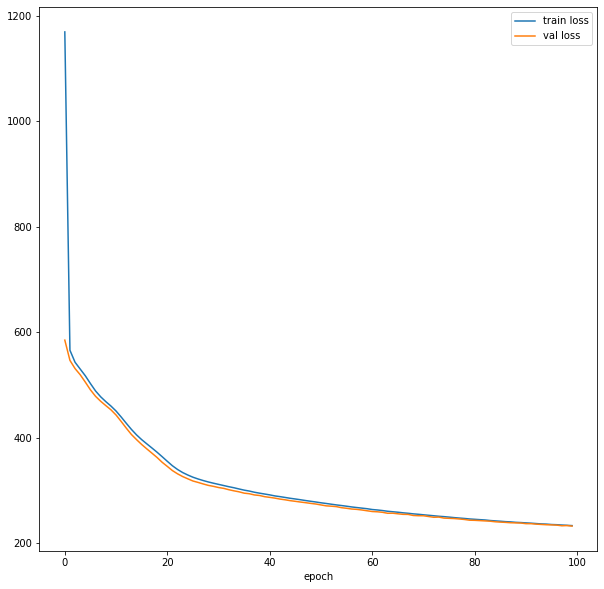

In [18]:
"""Plot training loss curve and save as image"""
plt.rcParams['figure.figsize'] = [10, 10]
loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
fig, ax = plt.subplots()
ax.plot(x_epochs, train_loss, label="train loss")
ax.plot(val_epochs, val_loss, label="val loss")
leg = ax.legend()
#plt.title()
plt.xlabel("epoch")
#plt.ylabel("loss")
plt.savefig(loss_img_file_name)
plt.show()
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, train_loss)
val_loss_txt_file_name = "val_loss.txt"
np.savetxt(val_loss_txt_file_name, val_loss)

In [19]:
train_state_file_path = train_state_dir + f"state_epoch_{epoch}"
#train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(net.state_dict(), train_state_file_path)
net_state_paths.append(train_state_file_path)
print(f"saved model from epoch {epoch}")

saved model from epoch 99


In [20]:
load_epoch = epoch
print(f"loading model from epoch {load_epoch}")
net_state_path = f"net_states/state_epoch_{load_epoch}"
net.load_state_dict(torch.load(net_state_path))
net.eval()

loading model from epoch 99


AutoEncoder(
  (encoder): Coder(
    (layers): ModuleList(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=392, bias=True)
      (2): Linear(in_features=392, out_features=196, bias=True)
      (3): Linear(in_features=196, out_features=98, bias=True)
      (4): Linear(in_features=98, out_features=20, bias=True)
    )
  )
  (decoder): Coder(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=49, bias=True)
      (1): Linear(in_features=49, out_features=98, bias=True)
      (2): Linear(in_features=98, out_features=196, bias=True)
      (3): Linear(in_features=196, out_features=784, bias=True)
      (4): Reshape()
    )
  )
)

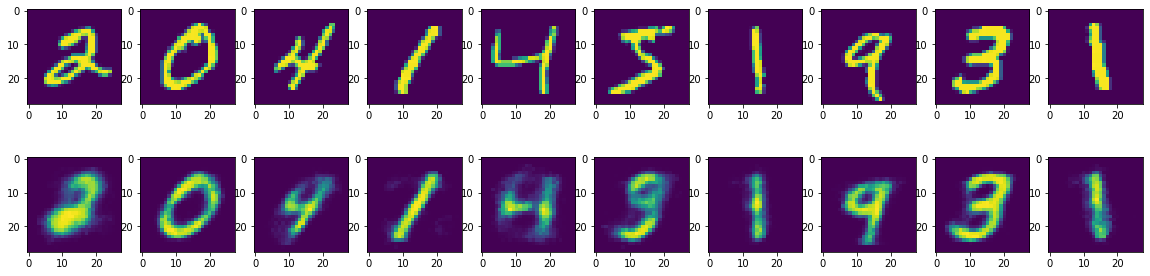

In [21]:
plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,10)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)

test_images = []
outputs = []
#for test_batch in train_loader:
for test_batch in val_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(test_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(2,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(outputs[image_i].detach().cpu()[0,0])

torch.Size([10, 1, 28, 28])
10


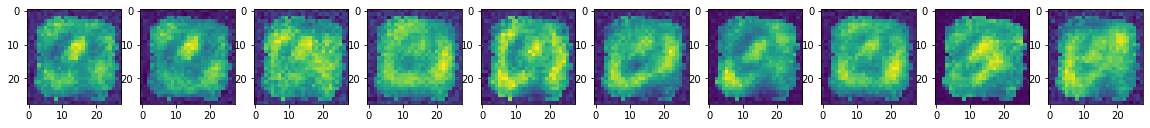

In [22]:
plt.rcParams['figure.figsize'] = [20, 5]
num_samples = 10
#latent_samples = torch.randint(low=1, high=1000, size=(num_samples, latent_size//2) )
latent_samples = torch.randn(size=(num_samples, latent_size//2) )

output = net.decoder(latent_samples.to(device).float())
print(output.size())
print(len(output))
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
    ax[i].imshow(output.detach().cpu()[i][0])
    

In [23]:
labels = np.array(dataset.label_df["number"], dtype=int)
sorted_label_indices = []
for class_num in range(0,10):
    sorted_label_indices.append(np.array(np.where(labels == class_num))[0])
    print(np.array(np.where(labels == class_num)).shape)
    
#print(len(sorted_label_indices))
#print(sorted_label_indices[0].size)
#print(sorted_label_indices[0][0])

(1, 1001)
(1, 1127)
(1, 991)
(1, 1032)
(1, 980)
(1, 863)
(1, 1014)
(1, 1070)
(1, 944)
(1, 978)


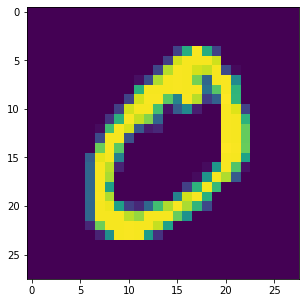

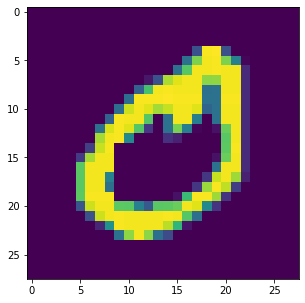

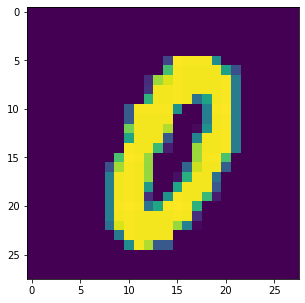

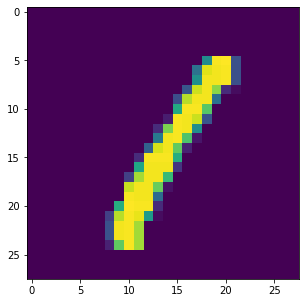

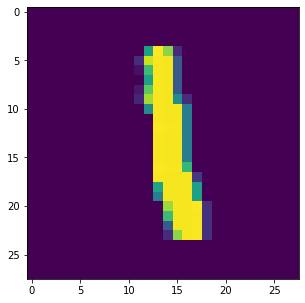

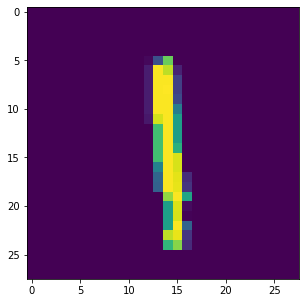

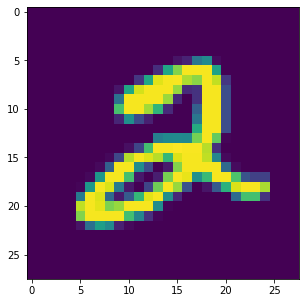

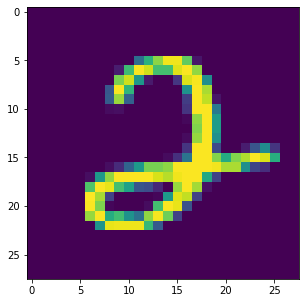

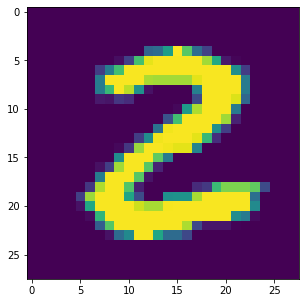

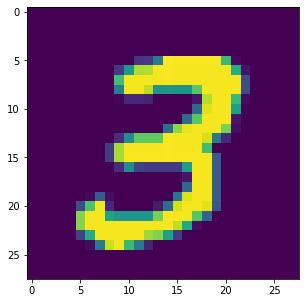

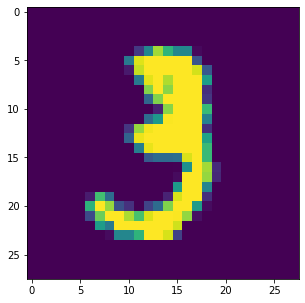

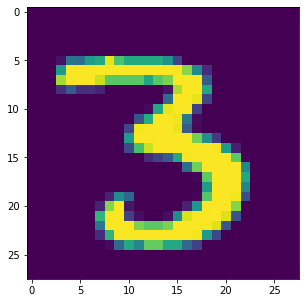

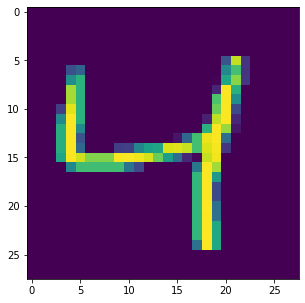

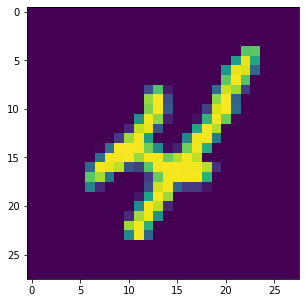

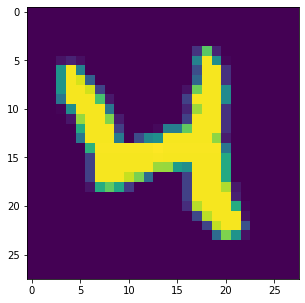

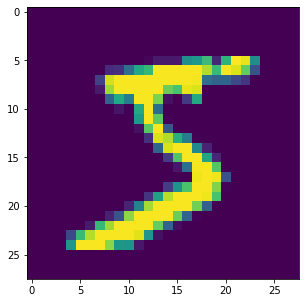

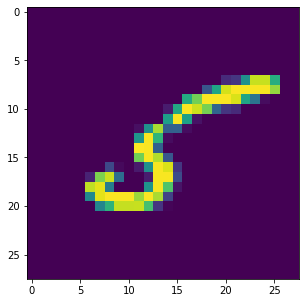

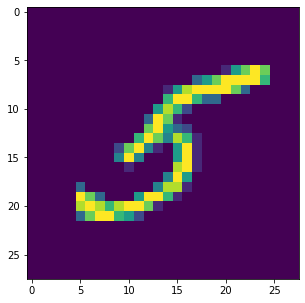

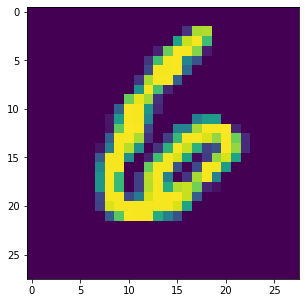

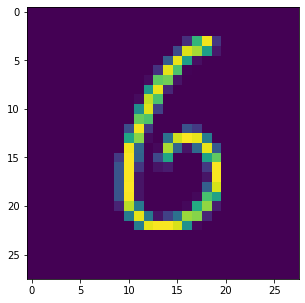

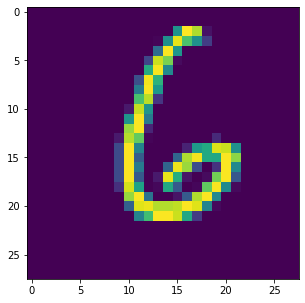

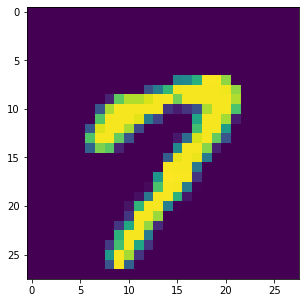

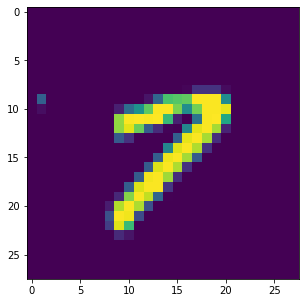

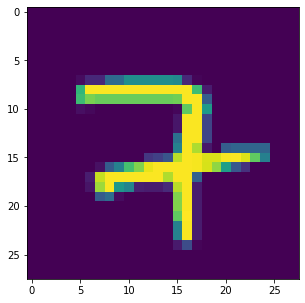

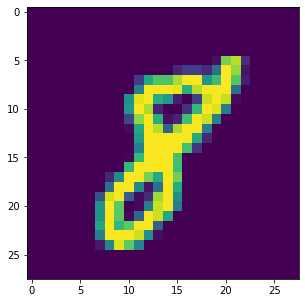

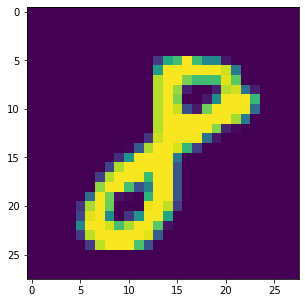

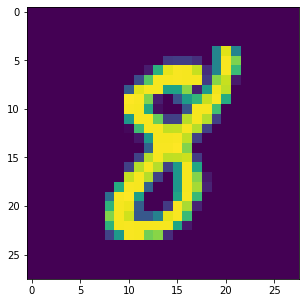

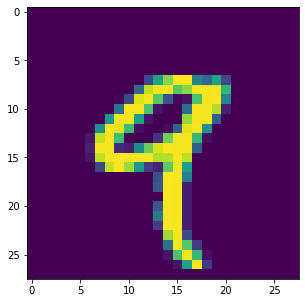

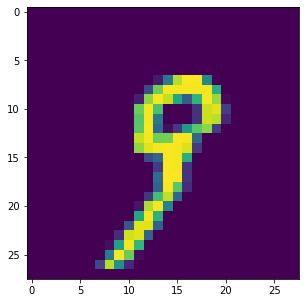

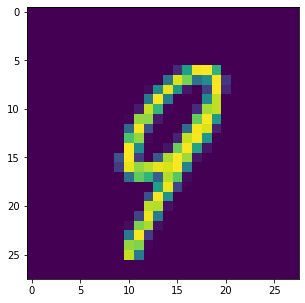

In [24]:
latent_vectors = []

for class_num in range(0,10):
    num_per_class = 800
    #num_per_class = len(sorted_label_indices[class_num]
    
    class_latent_vectors = np.zeros( (num_per_class,2,latent_size//2) )

    
    #for image_i in range(len(sorted_label_indices[class_num])):
    for image_i in tqdm(range(num_per_class)):
        #print(image_i)
        #get one image
        image_index = sorted_label_indices[class_num][image_i]
        #print(image_index)
        image = dataset.get_image(image_index)[0]
        if image_i < 3:
            plt.imshow(image.detach().cpu()[0])
            plt.show()
        
        #print(image.shape)
        
        #compress to latent space
        #net.encoder(image.float())
        net(image.float())
        
        #save latent variables
        latent_mu, log_latent_sigma = net.get_latent_variables()
        #print(latent_mu.size())
        class_latent_vectors[image_i][0] = latent_mu.detach().cpu()[0]
        class_latent_vectors[image_i][1] = log_latent_sigma.detach().cpu()[0]
        
    
    latent_vectors.append(class_latent_vectors)
    

In [25]:
latent_vectors = np.array(latent_vectors)
#log_var is saved as a latent variable
latent_vectors[:,:,1,:] = np.exp(latent_vectors[:,:,1,:])
print(latent_vectors.shape)

(10, 800, 2, 10)


In [26]:
mean_latent_vectors = latent_vectors.mean(axis=1)
std_latent_vector = latent_vectors.std(axis=1)
#cov_mu_latent_vector = np.cov(zero_latent_vectors[:,0])
#cov_sigma_latent_vector = np.cov(zero_latent_vectors[:,1])


print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print("mu")
    print(mean_latent_vectors[i][0])
    print("sigma")
    print(mean_latent_vectors[i][1])
    #print("std latent vector")
    #print(std_latent_vector[i])

mean latent vectors
number 0
mu
[10.93420112 16.77623375  7.96704498  4.63398463  6.55488621 11.02806317
  9.60564998  8.30076187 23.38562851  9.24548358]
sigma
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
number 1
mu
[ 5.35064319  9.30855371 13.65530992 18.05620683  3.63166855 10.15118471
  5.30932008 22.97433959  1.26487757  4.55435701]
sigma
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.00004054]
number 2
mu
[12.35856379  4.83156403  3.97013299  6.8969957   7.03013516 12.67715773
  5.76391276 13.90487059  8.84202418  6.87974781]
sigma
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
number 3
mu
[15.56091699 13.0617931  10.64027364  8.28572827  6.62129546  5.45985772
  4.34527111  8.96297114  5.74819951  4.39976709]
sigma
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
number 4
mu
[ 6.34757194  3.64317871 11.70560272 15.41954485 14.68575544 11.5465279
  6.89536842  7.6940777  12.7856389   5.24205267]
sigma
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
number 5
mu
[ 7.45778595 12.91690616  9.667

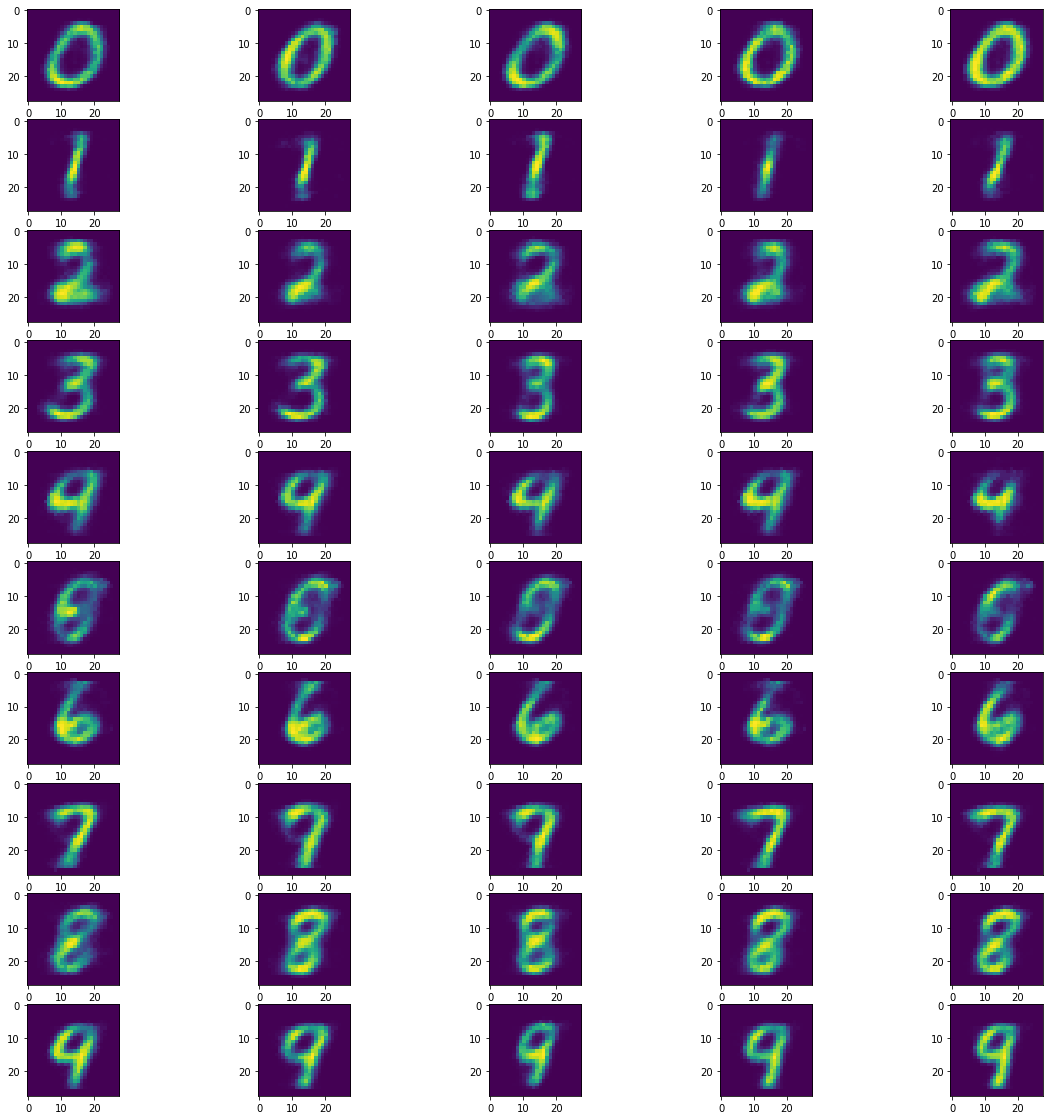

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
#gen_num = 2

ex_per_num = 5

fig, ax = plt.subplots(10,ex_per_num)

for gen_num in range(0,10):

    latent_shape = mean_latent_vectors[gen_num][0].shape
    #print(latent_shape)
    ex_shape = np.concatenate(([ex_per_num], latent_shape))
    #print(ex_shape)
    
    latent_z_sample = net.dist.sample(ex_shape).to(device)
    #print(latent_z_sample.size())
    mu = torch.tensor(mean_latent_vectors[gen_num][0]).to(device).float()
    log_sigma = torch.tensor(mean_latent_vectors[gen_num][1]).to(device).float()
    
    latent_sample = torch.zeros(tuple(ex_shape)).to(device).float()
    for ex in range(0,ex_per_num):
        latent_sample[ex] = mu + torch.exp(0.5*log_sigma)*latent_z_sample[ex]
    
    #print(latent_sample.size())
        
    ex_sample_images = net.decoder(latent_sample)
    
    #print(ex_sample_images.size())
    
    for ex in range(ex_per_num):
        ax[gen_num, ex].imshow(ex_sample_images[ex,:,:].detach().cpu().numpy()[0])

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [29]:
start = 2

interact_kwargs = {}
for i in range(0,latent_size//2):
    key = f"x{i}"
    #print(mean_latent_vectors.shape)
    mu = mean_latent_vectors[start][0][i]
    sigma = np.exp(mean_latent_vectors[start][1][i])
    #delta = 2*sigma
    delta = 6.
    low = mu - delta
    high = mu + delta
    interact_kwargs[key] = (low,high)

#interact_kwargs

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]
latent_vector = torch.zeros((latent_size//2)).to(device)

#@interact(x0=(-5.,5.), x1=(-5.,5.), x2=(-5.,5.), x3=(-5.,5.), x4=(-5.,5.), x5=(-5.,5.), x6=(-5.,5.), x7=(-5.,5.), x8=(-5.,5.), x9=(-5.,5.))
@interact(**interact_kwargs)
#def update_latent_vector(x0, x1, x2, x3, x4):
def update_latent_vector(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    
    latent_vector[0] = x0
    latent_vector[1] = x1
    latent_vector[2] = x2
    latent_vector[3] = x3
    latent_vector[4] = x4
    latent_vector[5] = x5
    latent_vector[6] = x6
    latent_vector[7] = x7
    latent_vector[8] = x8
    latent_vector[9] = x9
    print(latent_vector)
    image = net.decoder(latent_vector).detach().cpu().numpy()[0][0]
    plt.imshow(image)

interactive(children=(FloatSlider(value=12.358563789725302, description='x0', max=18.358563789725302, min=6.35…

In [31]:
for i in range(0,10):
    print(f"number {i}")
    print("mu")
    print(mean_latent_vectors[i][0])

number 0
mu
[10.93420112 16.77623375  7.96704498  4.63398463  6.55488621 11.02806317
  9.60564998  8.30076187 23.38562851  9.24548358]
number 1
mu
[ 5.35064319  9.30855371 13.65530992 18.05620683  3.63166855 10.15118471
  5.30932008 22.97433959  1.26487757  4.55435701]
number 2
mu
[12.35856379  4.83156403  3.97013299  6.8969957   7.03013516 12.67715773
  5.76391276 13.90487059  8.84202418  6.87974781]
number 3
mu
[15.56091699 13.0617931  10.64027364  8.28572827  6.62129546  5.45985772
  4.34527111  8.96297114  5.74819951  4.39976709]
number 4
mu
[ 6.34757194  3.64317871 11.70560272 15.41954485 14.68575544 11.5465279
  6.89536842  7.6940777  12.7856389   5.24205267]
number 5
mu
[ 7.45778595 12.91690616  9.66712747 10.27227054  6.89158827  5.65329669
  5.78736895  9.85126397 12.32201899  6.18230202]
number 6
mu
[ 5.60906031  6.25478029 10.76839352  4.56527853 15.12873433  7.50845977
  5.74173614 20.13231886 16.98733114  5.52241077]
number 7
mu
[ 4.08795291  3.23698228 17.25723521 15.9629

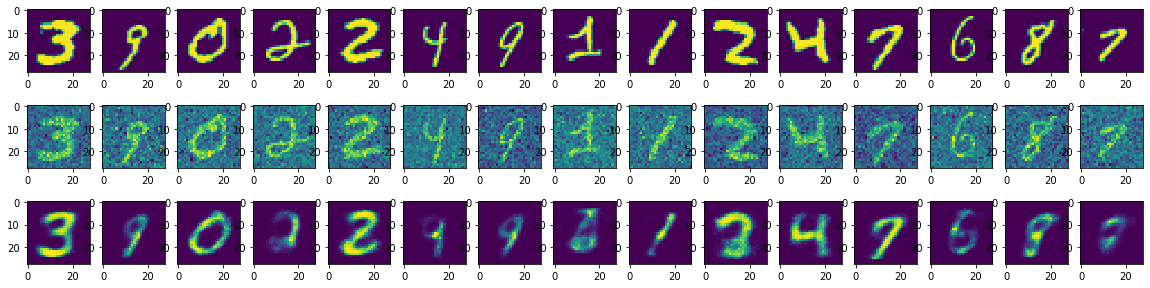

In [32]:
"""Denoising images"""

plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(15,30)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
noise_scale = 0.3
noise_func = torch.randn
noise_kwargs = {}

"""
dataset.transform = torchvision.transforms.Compose([
                #torchvision.transforms.ToTensor(),
                dataset_class_gsimage.min_max_scaler(device=device),
                dataset_class_gsimage.add_normal_noise(0.,0.1,device=device),
            ])
"""

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
            ])

#dataset.transform = None

val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
noisy_images = []
outputs = []
for test_batch in val_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    noise_kwargs["size"] = test_image.size()
    noise = noise_scale * noise_func(**noise_kwargs).to(device)
    noisy_image = test_image + noise
    noisy_images.append(noisy_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(noisy_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(3,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(noisy_images[image_i].detach().cpu()[0,0])
    ax[2, image_i].imshow(outputs[image_i].detach().cpu()[0,0])
    
    